### Package Downloading

In [3]:
# !pip install seaborn
# !pip install pandas_datareader
# !pip install tensorflow
# !pip install scikit-learn
# !pip install keras
# !pip install keras-tuner

In [4]:
# data source: https://www.kaggle.com/datasets/tanay001/nseindia-futures-options-daily
# India risk-free rate: https://fred.stlouisfed.org/series/INTDSRINM193N

In [5]:
# !pip install --upgrade quantstats

In [6]:
# !pip install numpy==1.26.4

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import polars as pl
import yfinance as yf
from datetime import timedelta
from datetime import datetime
import contextlib
import os
import sys
from io import StringIO
from scipy.stats import norm
from scipy.optimize import brentq
import swifter
import quantstats as qs
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Configure Polars
cfg = pl.Config()
cfg.set_tbl_rows(100)

# Configure Pandas
pd.set_option('display.max_rows', 100)

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

# number display settings
pd.set_option('display.float_format', '{:,.4f}'.format)

### Download full dataset and filter to options contracts

In [9]:
# Read CSV into a Polars DataFrame
df = pl.read_csv(
    "C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/fobhav.csv", 
    columns = [0,1,2,3,4,8,14], 
    schema_overrides={"EXPIRY_DT":str, "STRIKE_PR":str, "CLOSE":str}).drop_nulls()

df.head()
# close = closing price of derivative security
# timestamp = date recorded

INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,CLOSE,TIMESTAMP
str,str,str,str,str,str,str
"""FUTIDX""","""BANKNIFTY""","""24-Sep-2020""","""0.0""","""XX""","""23743.0""","""31-AUG-2020"""
"""FUTIDX""","""BANKNIFTY""","""29-Oct-2020""","""0.0""","""XX""","""23770.1""","""31-AUG-2020"""
"""FUTIDX""","""BANKNIFTY""","""26-Nov-2020""","""0.0""","""XX""","""23766.2""","""31-AUG-2020"""
"""FUTIDX""","""NIFTY""","""24-Sep-2020""","""0.0""","""XX""","""11401.95""","""31-AUG-2020"""
"""FUTIDX""","""NIFTY""","""29-Oct-2020""","""0.0""","""XX""","""11430.5""","""31-AUG-2020"""


In [10]:
# various types of instruments in dataset
# print(set(df["INSTRUMENT"]))

# filter to only stock options contracts
option_df = df.filter(pl.col("INSTRUMENT") == "OPTSTK")

# delete original df to save memory
del df

### Data Preprocessing and Sampling

#### Option Sampling

In [8]:
### DATA PREPROCESSING AND SAMPLING
# TAKE A RANDOM SAMPLE OF 50 COMPANIES FROM 2005 FOR ANALYSIS
# create new df to only look at 2007 options
# first year with at least 100 tickers is 2005. Use this 2007 as first year to get the most representative sample with good history
df_2007 = option_df.filter(pl.col("TIMESTAMP").str.ends_with("2007"))

# Get unique symbols that traded in 2007
unique_tickers_2007 = df_2007["SYMBOL"].unique().to_list()

# add NS after ticker for yf formatting
for i in range(len(unique_tickers_2007)):
    unique_tickers_2007[i] = unique_tickers_2007[i] + ".NS" 

available_tickers = []

# check for stocks that are still traded in 2020 and under the same ticker
for ticker in unique_tickers_2007:
    try:
        with contextlib.redirect_stderr(open(os.devnull, 'w')): # redirect error stream that flashes when no ticker data is found
            data = yf.download(ticker, start='2020-01-01', end='2020-01-15', progress=False)
            
        # if there is data to download, add it to available tickers
        if not data.empty:
            available_tickers.append(ticker)
            
    except Exception as e:
        # Ignore tickers that cause an error
        continue

print(f'There are {len(available_tickers)} available tickers')

YF.download() has changed argument auto_adjust default to True
There are 146 available tickers


In [9]:
# Sample 75 companies from those that traded in 2007
num_samples = 75
seed = 1234
rng = np.random.default_rng(seed)
final_tickers = rng.choice(sorted(available_tickers), size=num_samples, replace=False).tolist()

In [43]:
# Filter the original DataFrame for the sampled companies
base_tickers = [s.replace('.NS', '') for s in final_tickers]
final_tickers_df = option_df.filter(pl.col("SYMBOL").is_in(base_tickers))

# convert data types of columns
final_tickers_df = final_tickers_df.with_columns(pl.col(["EXPIRY_DT", "TIMESTAMP"]).str.to_date(format="%d-%b-%Y"))
final_tickers_df = final_tickers_df.with_columns(pl.col(["STRIKE_PR", "CLOSE"]).cast(pl.Float64))

# select only european options (CE = Call European, PE = Put European)
final_options = final_tickers_df.filter(pl.col("OPTION_TYP").is_in(["CE", "PE"]))

# select options where expiry is roughly one-two months away (27-63 days)
final_options = final_options.with_columns(DAYS_TO_EXPIRY = pl.col("EXPIRY_DT") - pl.col("TIMESTAMP"))
final_options = final_options.with_columns(DAYS_TO_EXPIRY_INT = (pl.col("DAYS_TO_EXPIRY") / pl.duration(days=1)).cast(pl.Int64)) # create new column that is int type
final_options = final_options.filter((pl.col("DAYS_TO_EXPIRY")<= timedelta(days=63)) & (pl.col("DAYS_TO_EXPIRY")>=timedelta(days=27)))
final_options = final_options.filter(pl.col("TIMESTAMP").dt.year() >= 2007) # found over 1500 options dated in the 1700s so this filter is needed

## DATA SET WITH FULL HISTORY OF OPTION (SECURITY) PRICES
final_options = final_options.to_pandas()
final_options.head()

,INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,CLOSE,TIMESTAMP,DAYS_TO_EXPIRY,DAYS_TO_EXPIRY_INT
0,OPTSTK,AMBUJACEM,2020-10-29,140.0,CE,83.25,2020-08-31,59 days,59
1,OPTSTK,AMBUJACEM,2020-10-29,145.0,CE,78.50,2020-08-31,59 days,59
2,OPTSTK,AMBUJACEM,2020-10-29,150.0,CE,73.80,2020-08-31,59 days,59
3,OPTSTK,AMBUJACEM,2020-10-29,155.0,CE,69.20,2020-08-31,59 days,59
4,OPTSTK,AMBUJACEM,2020-10-29,160.0,CE,64.70,2020-08-31,59 days,59


In [27]:
min_dt = min(final_options["TIMESTAMP"])
max_dt = max(final_options["TIMESTAMP"])

# print(min_dt)
# print(max_dt)
# print(sorted(final_tickers))

In [28]:
print(f'From our sample of {num_samples} stocks, we are left with options data for **{len(set(final_options["SYMBOL"]))}**.')

From our sample of 75 stocks, we are left with options data for **64**.


#### Pull in stock prices and calculate log returns

In [2]:
# final_tickers_df = pd.DataFrame(final_tickers, columns=['Ticker'])

# final_tickers_df.to_csv('final_tickers.csv', index=False)

final_tickers_df = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/final_tickers.csv")

In [3]:
final_tickers = []

for idx, row in final_tickers_df.iterrows():
    final_tickers.append(str(row[0]))

In [12]:
# downlaod stock return data
for i in final_tickers:
    returnName = i + "_LogRtn"
    closeName = i + "_Close"
    df = yf.download(i,
                     start = min_dt + timedelta(days=-90),
                     end   = '2020-12-31',
                     progress = True,
                     auto_adjust = False)

    df["logReturn"] = np.log(df["Adj Close"]/df["Adj Close"].shift(1)) # calculate daily log returns using the adjusted close

    df = df.loc[:,["Close", "logReturn"]] # keep the Close column for use with the options data

    df.rename(columns={"Close": closeName, "logReturn":returnName}, inplace= True) # rename for clarity in concatenated df

    if (i == final_tickers[0]):
        priceHistory = df
    else:  
        #combineRealizedVol = pd.concat([combinedRealizedVol, df_rv], axis=1)
        #can use merge or concat since the dataframes have the same number of rows       
        priceHistory = pd.concat([priceHistory, df], axis = 1)
        priceHistory.reset_index()

# many columns in priceHistory are tuples, making it difficult to transpose
# flatten the MultiIndex column names by only taking the first element
priceHistory.columns = [col[0] if isinstance(col, tuple) else col for col in priceHistory.columns]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
priceHistory.head()

,BHARATFORG.NS_Close,BHARATFORG.NS_LogRtn,JINDALSAW.NS_Close,JINDALSAW.NS_LogRtn,BOMDYEING.NS_Close,BOMDYEING.NS_LogRtn,TATASTEEL.NS_Close,TATASTEEL.NS_LogRtn,PURVA.NS_Close,PURVA.NS_LogRtn,...,KESORAMIND.NS_Close,KESORAMIND.NS_LogRtn,TITAN.NS_Close,TITAN.NS_LogRtn,AXISBANK.NS_Close,AXISBANK.NS_LogRtn,WOCKPHARMA.NS_Close,WOCKPHARMA.NS_LogRtn,VOLTAS.NS_Close,VOLTAS.NS_LogRtn
Date,,,,,,,,,,,,,,,,,,,,,
2010-08-27,176.899994,NaN,100.474998,NaN,114.250000,NaN,48.603859,NaN,111.949997,NaN,...,186.469635,NaN,149.117493,NaN,265.390015,NaN,201.005722,NaN,203.399994,NaN
2010-08-30,174.425003,-0.014090,99.425003,-0.010505,114.010002,-0.002103,50.294968,0.034202,109.050003,-0.026246,...,183.992157,-0.013375,149.927505,0.005417,264.790009,-0.002263,209.993591,0.043744,204.050003,0.003191
2010-08-31,174.899994,0.002720,100.974998,0.015469,110.260002,-0.033445,49.799545,-0.009899,109.449997,0.003661,...,183.960785,-0.000171,146.580002,-0.022580,266.130005,0.005048,202.388474,-0.036888,200.149994,-0.019298
2010-09-01,178.050003,0.017850,102.875000,0.018642,120.059998,0.085150,51.252468,0.028758,112.099998,0.023924,...,184.462555,0.002724,147.812500,0.008373,270.820007,0.017470,207.919464,0.026962,203.949997,0.018808
2010-09-02,179.500000,0.008111,103.525002,0.006299,121.239998,0.009781,51.833637,0.011276,112.400002,0.002673,...,186.595078,0.011494,150.017502,0.014808,277.609985,0.024763,206.997635,-0.004444,209.050003,0.024698


In [4]:
### SAVE PRICE HISTORY DF FOR FUTURE REFERENCE
# priceHistory.to_csv('priceHistory.csv', sep=',', index=True, header=True, encoding='utf-8')
priceHistory = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/priceHistory.csv", index_col = 0)

In [46]:
## RESHAPE DATA SET WITH FULL HISTORY OF UNDERLYING (STOCK) PRICES
## this way we can join back to the options dataset

# Reset index to get Date as a column
data = priceHistory.reset_index()

# Extract columns with _Close and _LogRtn
price_cols = [col for col in data.columns if col.endswith('_Close')]
logrtn_cols = [col for col in data.columns if col.endswith('_LogRtn')]

# Melt price columns
price_melted = data.melt(id_vars='Date', value_vars=price_cols,
                       var_name='Ticker', value_name='Price')
price_melted['Ticker'] = price_melted['Ticker'].str.replace('.NS_Close', '', regex=False)

# Melt log return columns
logrtn_melted = data.melt(id_vars='Date', value_vars=logrtn_cols,
                        var_name='Ticker', value_name='logReturn')
logrtn_melted['Ticker'] = logrtn_melted['Ticker'].str.replace('.NS_LogRtn', '', regex=False)

# Merge both melted dataframes on Date and Ticker
final_prices_rtn = pd.merge(price_melted, logrtn_melted, on=['Date', 'Ticker'])

# Preview
save_columns = ['Date', 'Ticker', 'Price']
final_prices = final_prices_rtn[save_columns]
final_prices['Date'] = pd.to_datetime(final_prices['Date']) # convert to date to ensure joining
final_prices.head()

,Date,Ticker,Price
0,2010-08-27,BHARATFORG,176.899994
1,2010-08-30,BHARATFORG,174.425003
2,2010-08-31,BHARATFORG,174.899994
3,2010-09-01,BHARATFORG,178.050003
4,2010-09-02,BHARATFORG,179.500000


In [47]:
final_prices_rtn.describe()

,Price,logReturn
count,191171.000000,191096.000000
mean,446.952685,0.000019
std,1633.464755,0.025723
min,0.350000,-0.771229
25%,61.599998,-0.012576
50%,134.100006,0.000000
75%,337.987503,0.011788
max,25012.699219,0.641218


#### Download risk-free rate data

In [9]:
# use FFR equivalent in India (one-year rF)
discount_rate = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/India_Int_Rate.csv")

# convert to datetime and extract month and year
discount_rate["observation_date"] = pd.to_datetime(discount_rate["observation_date"])
discount_rate["year_month"] = discount_rate["observation_date"].dt.to_period("M")

discount_rate

,observation_date,risk_free_rate,year_month
0,2010-01-01,0.0600,2010-01
1,2010-02-01,0.0600,2010-02
2,2010-03-01,0.0600,2010-03
3,2010-04-01,0.0600,2010-04
4,2010-05-01,0.0600,2010-05
...,...,...,...
127,2020-08-01,0.0425,2020-08
128,2020-09-01,0.0425,2020-09
129,2020-10-01,0.0425,2020-10
130,2020-11-01,0.0425,2020-11


#### Filter options to only those that are ATM

In [48]:
## JOIN OPTIONS DATA AND STOCK DATA BACK TOGETHER
master_options = pd.merge(final_options, final_prices, left_on=["TIMESTAMP", "SYMBOL"], right_on=["Date", "Ticker"], how='inner')

# join final prices again to see what the security price was at maturity
master_options = pd.merge(master_options, final_prices, left_on=["EXPIRY_DT", "SYMBOL"], right_on=["Date", "Ticker"], how='inner')
# rename columns for clarity
master_options = master_options.rename(columns={'Date_x': 'Date', 'Price_x': 'Price', 'Price_y': 'Price_Ex'})
# remove unnecessary columns
master_options = master_options.loc[:, ["INSTRUMENT", "SYMBOL", "Date", "EXPIRY_DT", "STRIKE_PR", "OPTION_TYP", \
                                        "CLOSE", "TIMESTAMP", "DAYS_TO_EXPIRY", "DAYS_TO_EXPIRY_INT", "Price", "Price_Ex"]]

## CALCULATE MONEYNESS
master_options["MONEYNESS"] = master_options["Price"] / master_options["STRIKE_PR"]
master_options["REL_MONEYNESS"] = abs(master_options["MONEYNESS"] - 1)

## FILTER DF SO THAT MONEYNESS IS VERY CLOSE TO 1.0
# only consider options that are trading within 1% of the stock price
atm_options =  master_options[master_options["REL_MONEYNESS"] <= 0.01]

## JOIN RISK FREE RATE DATA TO ATM OPTIONS FOR USE IN B-S
# extract year and month from Date
atm_options["year_month"] = atm_options["Date"].dt.to_period("M")
# Perform the merge on the year_month column
atm_options = pd.merge(atm_options, discount_rate, on="year_month", how="left")

print(f'There are {len(atm_options):,} options ATM\n')
atm_options.head(10)

There are 137,802 options ATM



,INSTRUMENT,SYMBOL,Date,EXPIRY_DT,STRIKE_PR,OPTION_TYP,CLOSE,TIMESTAMP,DAYS_TO_EXPIRY,DAYS_TO_EXPIRY_INT,Price,Price_Ex,MONEYNESS,REL_MONEYNESS,year_month,observation_date,risk_free_rate
0,OPTSTK,AMBUJACEM,2020-08-31,2020-10-29,210.0,CE,27.95,2020-08-31,59 days,59,210.550003,254.000000,1.002619,0.002619,2020-08,2020-08-01,0.0425
1,OPTSTK,AMBUJACEM,2020-08-31,2020-10-29,210.0,PE,14.30,2020-08-31,59 days,59,210.550003,254.000000,1.002619,0.002619,2020-08,2020-08-01,0.0425
2,OPTSTK,AMBUJACEM,2020-08-27,2020-10-29,220.0,CE,22.80,2020-08-27,63 days,63,221.350006,254.000000,1.006136,0.006136,2020-08,2020-08-01,0.0425
3,OPTSTK,AMBUJACEM,2020-08-27,2020-10-29,220.0,PE,19.05,2020-08-27,63 days,63,221.350006,254.000000,1.006136,0.006136,2020-08,2020-08-01,0.0425
4,OPTSTK,ASHOKLEY,2020-08-31,2020-10-29,67.0,CE,2.40,2020-08-31,59 days,59,67.650002,80.349998,1.009702,0.009702,2020-08,2020-08-01,0.0425
5,OPTSTK,ASHOKLEY,2020-08-31,2020-10-29,68.0,CE,2.25,2020-08-31,59 days,59,67.650002,80.349998,0.994853,0.005147,2020-08,2020-08-01,0.0425
6,OPTSTK,ASHOKLEY,2020-08-31,2020-10-29,67.0,PE,19.50,2020-08-31,59 days,59,67.650002,80.349998,1.009702,0.009702,2020-08,2020-08-01,0.0425
7,OPTSTK,ASHOKLEY,2020-08-31,2020-10-29,68.0,PE,20.30,2020-08-31,59 days,59,67.650002,80.349998,0.994853,0.005147,2020-08,2020-08-01,0.0425
8,OPTSTK,ASHOKLEY,2020-08-28,2020-10-29,70.0,CE,1.95,2020-08-28,62 days,62,70.500000,80.349998,1.007143,0.007143,2020-08,2020-08-01,0.0425
9,OPTSTK,ASHOKLEY,2020-08-28,2020-10-29,71.0,CE,1.85,2020-08-28,62 days,62,70.500000,80.349998,0.992958,0.007042,2020-08,2020-08-01,0.0425


#### Calculate implied volatilities of options to be analyzed

In [10]:
# Define the implied volatility function
def implied_volatility(row):
    """
    Compute implied volatility using the Black-Scholes formula.
    Iterate through a range of volatilities until B-S price - market price = 0
    
    Inputs:
    - optionPrice: Market price of the option (C)
    - sharePriceInitial: Current stock price (S)
    - strikePrice: Option strike price (K)
    - timeToExpiry: Time to expiration in years (T)
    - riskFree: Risk-free interest rate (r)
    - is_call: Boolean for it the option is a call (CE). This function only considers European options
    
    Output:
    - Implied volatility (sigma)
    """
    
    S = row['Price']
    K = row['STRIKE_PR']
    T = row['DAYS_TO_EXPIRY_INT'] / 365
    r = row['risk_free_rate']
    C = row['CLOSE']
    is_call = row['OPTION_TYP'] == 'CE'  # Assuming all lowercase

    sqrt_T = np.sqrt(T)
    
    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        if is_call:
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def objective(sigma):
        return bs_price(sigma) - C

    try:
        return brentq(objective, 1e-4, 4.0, maxiter=500)
    except Exception:
        return np.nan

In [50]:
# Apply the function row by row and create the "IV" column
# use switfter to speed up processing power (~2 min 45 sec runtime)
# roughly 3000 rows don't converge, but appears to be data error. Option prices are extremely high with IV likely above upper bound

atm_options['IV'] = atm_options.swifter.apply(implied_volatility, axis=1)

Pandas Apply: 100%|██████████| 137802/137802 [02:12<00:00, 1038.17it/s]


In [54]:
iv_summary = atm_options.loc[:, ["SYMBOL", "TIMESTAMP", "EXPIRY_DT", "DAYS_TO_EXPIRY_INT", "Price", "Price_Ex", "STRIKE_PR", "OPTION_TYP", "CLOSE", "IV"]]

In [55]:
# find the sector of each stock in the sample and map in datatframe
symbol_sectors = {}
for ticker in final_tickers:
    stock = yf.Ticker(ticker)
    sector = stock.info.get("sector")
    symbol_sectors[ticker] = sector

# manually fill in tickers that got missed using yahoo finance
symbol_sectors['PUNJLLOYD.NS'] = 'Energy'
symbol_sectors['IVRCLINFRA.NS'] = 'Industrials'
symbol_sectors['GITANJALI.NS'] = 'Industrials'

iv_summary['SECTOR'] = (iv_summary['SYMBOL']+'.NS').map(symbol_sectors)

In [192]:
# iv_summary.to_csv('option_iv_summary.csv', sep=',', index=False, header=True, encoding='utf-8')

#### Calculate realized volatilities of the underlying stocks to expiry

In [3]:
iv_summary = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/option_iv_summary.csv")
iv_rv_summary = iv_summary # create duplicate for including realized volatilities

In [17]:
iv_summary.head()

,SYMBOL,TIMESTAMP,EXPIRY_DT,DAYS_TO_EXPIRY_INT,Price,Price_Ex,STRIKE_PR,OPTION_TYP,CLOSE,IV,SECTOR
0,AMBUJACEM,2020-08-31,2020-10-29,59,210.550003,254.000000,210.0,CE,27.95,0.805148,Basic Materials
1,AMBUJACEM,2020-08-31,2020-10-29,59,210.550003,254.000000,210.0,PE,14.30,0.455041,Basic Materials
2,AMBUJACEM,2020-08-27,2020-10-29,63,221.350006,254.000000,220.0,CE,22.80,0.585621,Basic Materials
3,AMBUJACEM,2020-08-27,2020-10-29,63,221.350006,254.000000,220.0,PE,19.05,0.563695,Basic Materials
4,ASHOKLEY,2020-08-31,2020-10-29,59,67.650002,80.349998,67.0,CE,2.40,0.166487,Industrials


In [18]:
# Define the realized volatility function
def realized_volatility(row):
    start = str(row["TIMESTAMP"])
    end = str(row["EXPIRY_DT"])
    ticker = str(row["SYMBOL"])
    days_to_exp = int(row["DAYS_TO_EXPIRY_INT"])

    # create empty dictionary to hold volatility measures
    real_volatilities = {}
    
    # pull returns of stock from the PriceHistory df based on the option contract
    returns = priceHistory.loc[start:end, [ticker+'.NS_LogRtn']]

    # calculate the standard deviation of returns for realized volatility
    # scale to annual level by multiplying by sqrt(252)
    real_volatilities["STD_RV"] = np.std(returns.values) * np.sqrt(252)

    # calculate the exponentially weighted moving average standard deviation
    real_volatilities["EWMA_RV"] = returns.ewm(alpha=0.2, adjust=False).std().mean().values[0] * np.sqrt(252)

    # calculate a 5-day rolling standard deviation of log returns
    real_volatilities["ROLL_RV"] = returns.rolling(window=5).std().mean().values[0] * np.sqrt(252)

    # calculate Root Sum of Squares realized volatiltiy of the stock during
    # looks at volatiltiy for whole period, so scale by the amount of days remaining in the year
    real_volatilities["RSS_RV"] = np.sqrt(np.sum(returns.values**2)) * np.sqrt(252 / days_to_exp)
    
    return real_volatilities

In [19]:
# apply the realized volatility function
# ~2 min 30 runtime
iv_rv_summary = iv_rv_summary.join(
    iv_rv_summary.swifter.apply(realized_volatility, axis=1).apply(pd.Series)
)

Pandas Apply: 100%|██████████| 137802/137802 [01:53<00:00, 1214.70it/s]


In [20]:
iv_rv_summary.head()

,SYMBOL,TIMESTAMP,EXPIRY_DT,DAYS_TO_EXPIRY_INT,Price,Price_Ex,STRIKE_PR,OPTION_TYP,CLOSE,IV,SECTOR,STD_RV,EWMA_RV,ROLL_RV,RSS_RV
0,AMBUJACEM,2020-08-31,2020-10-29,59,210.550003,254.000000,210.0,CE,27.95,0.805148,Basic Materials,0.353032,0.388327,0.311495,0.304271
1,AMBUJACEM,2020-08-31,2020-10-29,59,210.550003,254.000000,210.0,PE,14.30,0.455041,Basic Materials,0.353032,0.388327,0.311495,0.304271
2,AMBUJACEM,2020-08-27,2020-10-29,63,221.350006,254.000000,220.0,CE,22.80,0.585621,Basic Materials,0.345132,0.330438,0.319292,0.294654
3,AMBUJACEM,2020-08-27,2020-10-29,63,221.350006,254.000000,220.0,PE,19.05,0.563695,Basic Materials,0.345132,0.330438,0.319292,0.294654
4,ASHOKLEY,2020-08-31,2020-10-29,59,67.650002,80.349998,67.0,CE,2.40,0.166487,Industrials,0.554956,0.556823,0.500991,0.475559


In [21]:
# iv_rv_summary.to_csv('iv_rv_summary.csv', sep=',', index=False, header=True, encoding='utf-8')

### Exploratory Analysis of Options Data

In [5]:
iv_rv_summary = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/iv_rv_summary.csv")
iv_rv_summary[['STD_RV', 'EWMA_RV', 'ROLL_RV', 'RSS_RV']].describe()

,STD_RV,EWMA_RV,ROLL_RV,RSS_RV
count,"137,802.0000","137,802.0000","137,802.0000","137,802.0000"
mean,0.3132,0.3013,0.2930,0.2678
std,0.1412,0.1309,0.1270,0.1204
min,0.0568,0.0473,0.0462,0.0495
25%,0.2209,0.2133,0.2081,0.1890
50%,0.2818,0.2728,0.2651,0.2404
75%,0.3640,0.3542,0.3420,0.3113
max,3.2176,2.2544,2.6745,2.7630


In [3]:
## USE PRICE AT EXPIRY TO CALCULATE PAYOFF FOR OPTION TYPES
def calculate_payoff(row):
    if row["OPTION_TYP"] == 'CE':  # Call option
        return max(row["Price_Ex"] - row["STRIKE_PR"], 0)
    else:  # Put option
        return max(row["STRIKE_PR"] - row["Price_Ex"], 0)

## Calculate payoff, profit, and returns of the options
iv_rv_summary["Payoff"] = iv_rv_summary.apply(calculate_payoff, axis=1)
iv_rv_summary["Profit"] = iv_rv_summary["Payoff"] - iv_rv_summary["CLOSE"]
iv_rv_summary["ROI"] = (iv_rv_summary["Payoff"] / iv_rv_summary["CLOSE"]) - 1

In [4]:
## Consumer cyclical has the most options data
# use this is the baseline category for model building
iv_rv_summary.groupby('SECTOR')['SYMBOL'].count().sort_values()

SECTOR
Real Estate                 538
Utilities                  5396
Technology                 7204
Energy                     8052
Communication Services     8132
Industrials                8398
Healthcare                10384
Consumer Defensive        17638
Financial Services        18632
Basic Materials           21288
Consumer Cyclical         32140
Name: SYMBOL, dtype: int64

In [5]:
iv_rv_summary.groupby('OPTION_TYP')['Payoff'].agg(['mean', 'median', 'max'])

,mean,median,max
OPTION_TYP,,,
CE,57.703881,0.75,4808.900391
PE,62.257620,0.00,7445.949219


In [6]:
iv_rv_summary.groupby('OPTION_TYP')['ROI'].agg(['mean', 'median', 'max'])

,mean,median,max
OPTION_TYP,,,
CE,-0.033060,-0.969004,179.999985
PE,3.822632,-1.000000,4978.000244


In [7]:
iv_rv_summary["ROI"].describe()

count    137802.000000
mean          1.894786
std          41.531357
min          -1.000000
25%          -1.000000
50%          -1.000000
75%           0.253772
max        4978.000244
Name: ROI, dtype: float64

Most options expire worthless, with a median payoff of roughly 0 and ROI of -100%.  
However, the distribution of returns is extremely right skewed, with some returns near 500,000%

In [8]:
# Count instances where call options are ITM
ce_in_the_money_count = iv_rv_summary[
    (iv_rv_summary["OPTION_TYP"] == "CE") & 
    (iv_rv_summary["Price_Ex"] > iv_rv_summary["STRIKE_PR"])
].shape[0]

# What percentage are ITM?
total_ce_options = iv_rv_summary[iv_rv_summary["OPTION_TYP"] == "CE"].shape[0]
percentage = (ce_in_the_money_count / total_ce_options * 100)

print(f"Percentage of call options that are in-the-money: {percentage:.2f}%")

Percentage of call options that are in-the-money: 51.16%


In [9]:
# Count instances where put options are ITM
pe_in_the_money_count = iv_rv_summary[
    (iv_rv_summary["OPTION_TYP"] == "PE") & 
    (iv_rv_summary["STRIKE_PR"] > iv_rv_summary["Price_Ex"])
].shape[0]

# What percentage are ITM?
total_pe_options = iv_rv_summary[iv_rv_summary["OPTION_TYP"] == "PE"].shape[0]
percentage = (pe_in_the_money_count / total_pe_options * 100)

print(f"Percentage of put options that are in-the-money: {percentage:.2f}%")

Percentage of put options that are in-the-money: 48.73%


The percentage of options that expire ITM is roughly 50%, indicating the probability of an option finishing with a positive payoff is roughly 50%.

In [10]:
## BIG RETURNS ARE ALL WITH PUT OPTIONS
iv_rv_summary.sort_values(by="ROI", ascending=False).head(10)

,SYMBOL,TIMESTAMP,EXPIRY_DT,DAYS_TO_EXPIRY_INT,Price,Price_Ex,STRIKE_PR,OPTION_TYP,CLOSE,IV,SECTOR,STD_RV,EWMA_RV,ROLL_RV,RSS_RV,Payoff,Profit,ROI
51337,STAR,2018-04-26,2018-06-28,63,640.799988,391.049988,640.0,PE,0.05,0.015549,Healthcare,0.876116,0.743445,0.665301,0.754690,248.950012,248.900012,4978.000244
51335,STAR,2018-04-27,2018-06-28,62,636.349976,391.049988,640.0,PE,0.05,0.007588,Healthcare,0.885231,0.751440,0.675502,0.760697,248.950012,248.900012,4978.000244
51333,STAR,2018-04-30,2018-06-28,59,637.500000,391.049988,640.0,PE,0.05,0.009360,Healthcare,0.895405,0.777474,0.686413,0.779664,248.950012,248.900012,4978.000244
10279,INDUSINDBK,2020-03-17,2020-04-30,44,604.150024,468.149994,600.0,PE,0.05,0.019391,Financial Services,1.944452,1.866526,1.765046,1.586224,131.850006,131.800006,2636.000122
133537,TCS,2011-07-01,2011-08-25,55,595.950012,475.200012,600.0,PE,0.05,0.004562,Technology,0.345398,0.274351,0.298893,0.300238,124.799988,124.749988,2494.999756
133535,TCS,2011-07-07,2011-08-25,49,597.950012,475.200012,600.0,PE,0.05,0.008285,Technology,0.362334,0.308427,0.314945,0.317238,124.799988,124.749988,2494.999756
122323,TCS,2013-03-07,2013-04-25,49,794.950012,701.150024,800.0,PE,0.05,0.008388,Technology,0.193125,0.202107,0.186189,0.161892,98.849976,98.799976,1975.999512
130777,BATAINDIA,2011-11-04,2011-12-29,55,362.024994,267.075012,360.0,PE,0.05,0.021677,Consumer Cyclical,0.467661,0.412514,0.445391,0.398127,92.924988,92.874988,1857.499756
130783,BATAINDIA,2011-10-31,2011-12-29,59,362.274994,267.075012,360.0,PE,0.05,0.022482,Consumer Cyclical,0.452953,0.408635,0.416638,0.388580,92.924988,92.874988,1857.499756
130781,BATAINDIA,2011-11-02,2011-12-29,57,359.549988,267.075012,360.0,PE,0.05,0.013314,Consumer Cyclical,0.457254,0.397298,0.429130,0.392614,92.924988,92.874988,1857.499756


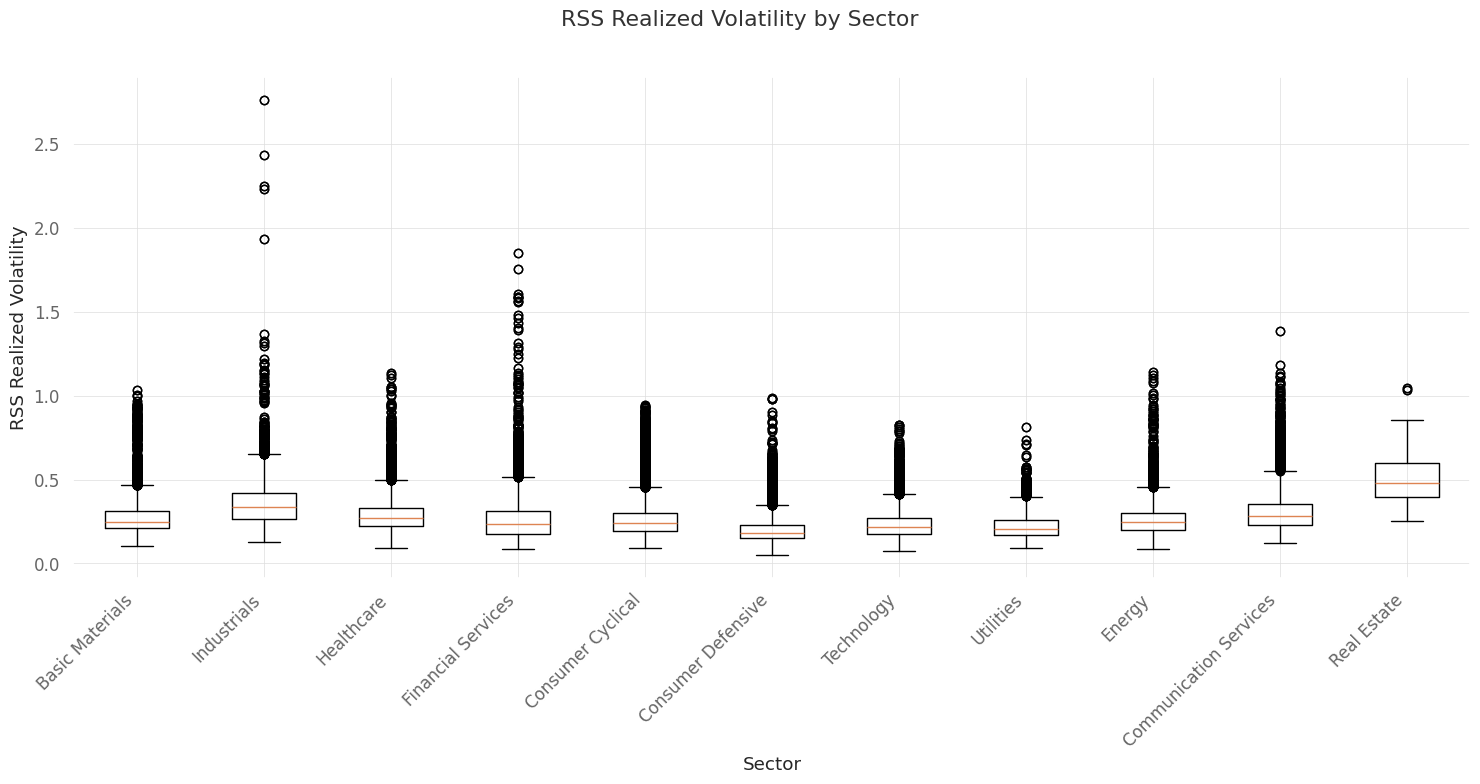

In [11]:
# Group the data by sector
sectors = list(iv_rv_summary['SECTOR'].unique())  # Get unique non-null sectors
sector_data = []

for sector in sectors:
    # Filter data for each sector
    sector_values = iv_rv_summary[iv_rv_summary['SECTOR'] == sector]['RSS_RV']
    sector_data.append(sector_values)

# Create the boxplot
fig = plt.figure(figsize=(15, 8))
fig.suptitle('RSS Realized Volatility by Sector')
ax = fig.add_subplot(111)
bp = plt.boxplot(sector_data)

# Set the x-tick labels to sector names
ax.set_xticklabels(sectors, rotation=45, ha='right')

# Add labels
plt.ylabel('RSS Realized Volatility')
plt.xlabel('Sector')
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to accommodate title
plt.show()

### Predictive Modeling (Training)

#### Set up training data (2010-2017)

In [6]:
training = iv_rv_summary[iv_rv_summary['EXPIRY_DT'] <= '2017-12-31']
training

,SYMBOL,TIMESTAMP,EXPIRY_DT,DAYS_TO_EXPIRY_INT,Price,Price_Ex,STRIKE_PR,OPTION_TYP,CLOSE,IV,SECTOR,STD_RV,EWMA_RV,ROLL_RV,RSS_RV
62394,AMBUJACEM,2017-12-01,2017-12-28,27,263.5500,271.6000,265.0000,CE,7.1500,0.2539,Basic Materials,0.1599,0.1507,0.1729,0.1363
62395,AMBUJACEM,2017-12-01,2017-12-28,27,263.5500,271.6000,265.0000,PE,7.7500,0.2670,Basic Materials,0.1599,0.1507,0.1729,0.1363
62396,AMBUJACEM,2017-11-30,2017-12-28,28,262.5000,271.6000,260.0000,CE,9.4000,0.2562,Basic Materials,0.1565,0.1414,0.1678,0.1340
62397,AMBUJACEM,2017-11-30,2017-12-28,28,262.5000,271.6000,265.0000,CE,7.1000,0.2649,Basic Materials,0.1565,0.1414,0.1678,0.1340
62398,AMBUJACEM,2017-11-30,2017-12-28,28,262.5000,271.6000,260.0000,PE,5.8500,0.2631,Basic Materials,0.1565,0.1414,0.1678,0.1340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137797,ZEEL,2010-12-02,2011-01-27,56,149.9000,117.9500,150.0000,PE,27.5000,1.2176,Communication Services,0.4379,0.3773,0.3435,0.3723
137798,ZEEL,2010-11-29,2011-01-27,59,140.5500,117.9500,140.0000,CE,18.2000,0.7727,Communication Services,0.4292,0.3433,0.3378,0.3667
137799,ZEEL,2010-11-29,2011-01-27,59,140.5500,117.9500,140.0000,PE,15.8000,0.7502,Communication Services,0.4292,0.3433,0.3378,0.3667
137800,ZEEL,2010-11-25,2011-01-27,63,141.3500,117.9500,140.0000,CE,18.2000,0.7256,Communication Services,0.4197,0.3297,0.3324,0.3555


In [13]:
vols = training[['IV', 'STD_RV', 'EWMA_RV', 'ROLL_RV', 'RSS_RV']]

In [14]:
vols_diff = pd.DataFrame()
vols_diff['STD_diff_abs'] = abs(vols['STD_RV'] - vols['IV'])
vols_diff['EWMA_diff_abs'] = abs(vols['EWMA_RV'] - vols['IV'])
vols_diff['ROLL_diff_abs'] = abs(vols['ROLL_RV'] - vols['IV'])
vols_diff['RSS_diff_abs'] = abs(vols['RSS_RV'] - vols['IV'])
vols_diff['STD_diff'] = vols['STD_RV'] - vols['IV']
vols_diff['EWMA_diff'] = vols['EWMA_RV'] - vols['IV']
vols_diff['ROLL_diff'] = vols['ROLL_RV'] - vols['IV']
vols_diff['RSS_diff'] = vols['RSS_RV'] - vols['IV']

In [15]:
vols_diff.describe()

,STD_diff_abs,EWMA_diff_abs,ROLL_diff_abs,RSS_diff_abs,STD_diff,EWMA_diff,ROLL_diff,RSS_diff
count,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000
mean,0.305231,0.308778,0.312085,0.322504,-0.226000,-0.236849,-0.246383,-0.269974
std,0.467308,0.470400,0.473291,0.479029,0.510360,0.510415,0.510585,0.510481
min,0.000005,0.000002,0.000001,0.000001,-3.816114,-3.836980,-3.832282,-3.844206
25%,0.058604,0.059612,0.061515,0.069169,-0.305186,-0.318052,-0.327936,-0.347511
50%,0.140457,0.142452,0.143801,0.150576,-0.077484,-0.086344,-0.093417,-0.114661
75%,0.335738,0.340804,0.345060,0.359183,0.028637,0.018806,0.010906,-0.014466
max,3.816114,3.836980,3.832282,3.844206,1.085784,1.131079,0.851063,0.929307


Based on the summary statistics, using the standard deviation of returns has the smallest MAE on average.  
The RSS average is performing the worst.  
All models show that IV is underestimating the volatility (negative residuals). The standard deviation is the most unbiased with the smallest mean difference.  

#### Select data to be used in model building

In [16]:
model_data = training.loc[:, ["SYMBOL", "TIMESTAMP", "EXPIRY_DT", "DAYS_TO_EXPIRY_INT", "OPTION_TYP", "IV", \
                              "SECTOR", "STD_RV", "EWMA_RV", "ROLL_RV", "RSS_RV"]]

In [4]:
# get 3 month historical volatility using daily returns to be as input feature
# use same realized_volatility logic from previous function
def historical_stats(row):
    timestamp = pd.to_datetime(str(row["TIMESTAMP"]))
    
    start = str(timestamp + timedelta(days = -90))
    end = str(timestamp)
    ticker = row["SYMBOL"]
    
    # create empty dictionary to hold volatility measures
    real_volatilities = {}
    
    # pull returns of stock from the PriceHistory df based on the option contract
    returns = priceHistory.loc[start:end, [ticker+'.NS_LogRtn']]
    # drop any nulls to avoid issues in the calculations
    returns = returns.dropna()

    # calculate the standard deviation of returns for realized volatility
    # scale to annual level by multiplying by sqrt(252)
    real_volatilities["STD_RV_90"] = np.std(returns.values) * np.sqrt(252)

    # calculate the exponentially weighted moving average standard deviation
    real_volatilities["EWMA_RV_90"] = returns.ewm(alpha=0.2, adjust=False).std().mean().values[0] * np.sqrt(252)

    # calculate a 5-day rolling standard deviation of log returns
    real_volatilities["ROLL_RV_90"] = returns.rolling(window=5).std().mean().values[0] * np.sqrt(252)

    # calculate Root Sum of Squares realized volatiltiy of the stock during
    # looks at volatiltiy for whole period, so scale by the amount of days remaining in the year
    real_volatilities["RSS_RV_90"] = np.sqrt(np.sum(returns.values**2)) * np.sqrt(252 / 90)

    # calculate 90-day log return leading up to the purchase date (timestamp)
    real_volatilities["TOTAL_RTN_90"] = np.exp(np.sum(returns.values))-1   
    
    return real_volatilities

In [43]:
# ~1 min 30 sec runtime
model_data = model_data.join(
    model_data.swifter.apply(historical_stats, axis=1).apply(pd.Series)
)

Pandas Apply: 100%|██████████| 75408/75408 [01:33<00:00, 805.27it/s]


#### Download Model Data and Prepare for Analysis

In [7]:
# model_data.to_csv('train_model_data.csv', sep=',', index=False, header=True, encoding='utf-8')
model_data = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/train_model_data.csv")

In [6]:
# print(model_data.describe())
# missing values in IV column based on inability to merge

# drop rows with null IV
model_data = model_data.dropna(subset=['IV'])

<Figure size 1500x1500 with 0 Axes>

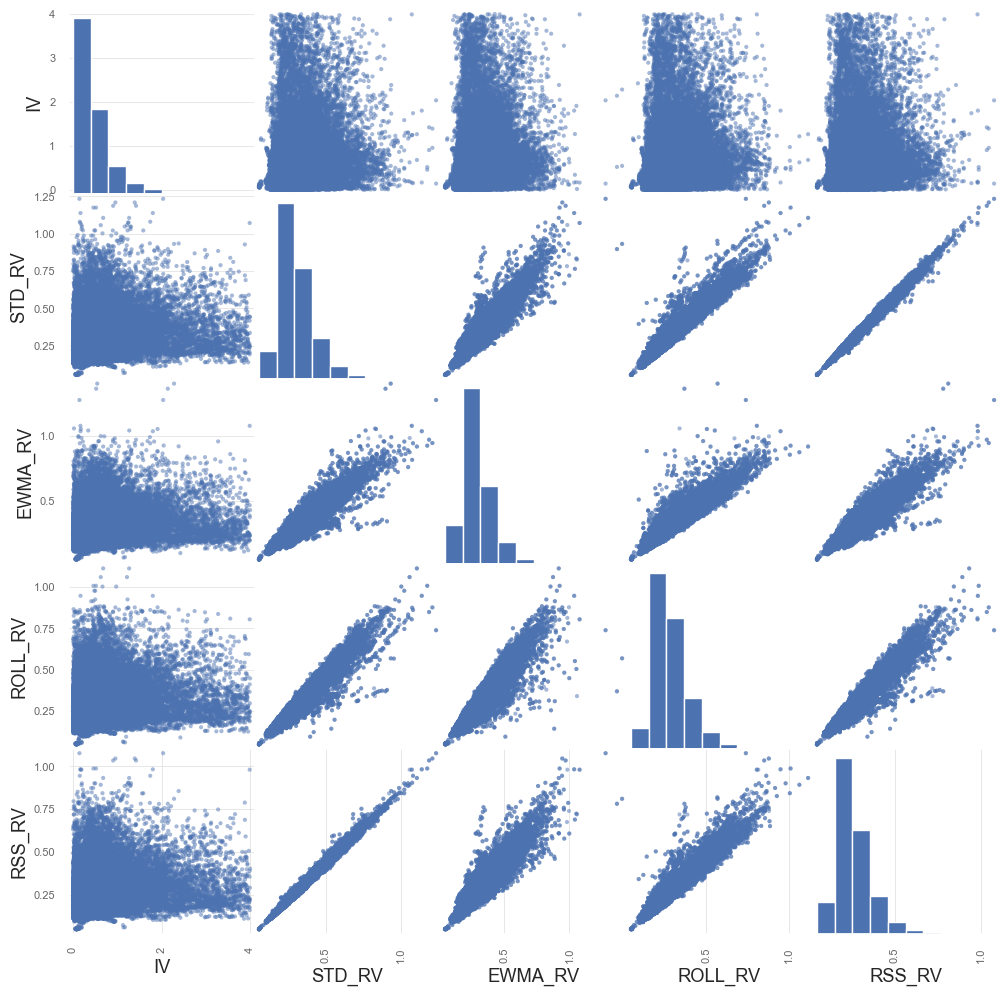

,IV,STD_RV,EWMA_RV,ROLL_RV,RSS_RV
IV,1.000000,0.205900,0.204891,0.202985,0.204175
STD_RV,0.205900,1.000000,0.949469,0.962569,0.995812
EWMA_RV,0.204891,0.949469,1.000000,0.936814,0.943849
ROLL_RV,0.202985,0.962569,0.936814,1.000000,0.958445
RSS_RV,0.204175,0.995812,0.943849,0.958445,1.000000


In [7]:
## build scatter plot comparing IV (x) and RV (y)
scatter_data = model_data.loc[:, ['IV', 'STD_RV', 'EWMA_RV', 'ROLL_RV', 'RSS_RV']]

# scatter matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(scatter_data,figsize=(12,12))
pyplot.show()

print("\n")
# correlation matrix
scatter_data.corr()

**Standard deviation and RSS methods are most correlated with IV (above .20)**

In [18]:
## only IV is highly skewed
model_data.describe()

,DAYS_TO_EXPIRY_INT,IV,STD_RV,EWMA_RV,ROLL_RV,RSS_RV,STD_RV_90,EWMA_RV_90,ROLL_RV_90,RSS_RV_90,TOTAL_RTN_90
count,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000,73093.000000
mean,44.178157,0.531116,0.305116,0.294267,0.284733,0.261142,0.315178,0.300508,0.287558,0.260936,0.051359
std,10.825270,0.521437,0.117244,0.113292,0.107790,0.101025,0.107640,0.099511,0.094487,0.089109,0.170528
min,27.000000,0.000476,0.056772,0.047274,0.046249,0.049527,0.131998,0.129269,0.125610,0.109970,-0.624060
25%,35.000000,0.248299,0.221846,0.213427,0.207829,0.189645,0.238247,0.228859,0.218206,0.197828,-0.057625
50%,44.000000,0.365682,0.281204,0.271565,0.262050,0.239567,0.294874,0.281733,0.270284,0.244057,0.048163
75%,53.000000,0.613692,0.360543,0.348514,0.336190,0.307572,0.370804,0.351349,0.335647,0.306384,0.149607
max,63.000000,3.999829,1.232280,1.404058,1.113079,1.075803,1.044398,0.948343,0.793836,0.890988,2.024000


In [8]:
## create new variable that takes the log of IV
model_data['ln_IV'] = np.log(model_data['IV'])

model_data.loc[:, ['IV', 'ln_IV']].describe()

,IV,ln_IV
count,73093.000000,73093.000000
mean,0.531116,-0.989263
std,0.521437,0.893990
min,0.000476,-7.649543
25%,0.248299,-1.393120
50%,0.365682,-1.005991
75%,0.613692,-0.488262
max,3.999829,1.386252


In [9]:
# select data to be used in models
# IV, option type, days to expiry, Sector, 90 day lag return, 90 day lag volatility
STD_training_X = model_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'STD_RV_90']]
STD_training_y = model_data.loc[:, ['STD_RV']]

EWMA_training_X = model_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'EWMA_RV_90']]
EWMA_training_y = model_data.loc[:, ['EWMA_RV']]

ROLL_training_X = model_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'ROLL_RV_90']]
ROLL_training_y = model_data.loc[:, ['ROLL_RV']]

RSS_training_X = model_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'RSS_RV_90']]
RSS_training_y = model_data.loc[:, ['RSS_RV']]

In [25]:
# data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def model_preprocessing(model, data='training'):
    categorical_cols = ['OPTION_TYP', 'SECTOR']
    numerical_cols = ['IV', 'ln_IV', 'DAYS_TO_EXPIRY_INT', 'TOTAL_RTN_90', f'{model}_RV_90']
    
    # Access the dataframe with the matching name
    if data == 'training':
        data = globals()[f'{model}_training_X'].copy()
    else:
        data = globals()[f'{model}_testing_X'].copy()

    # One-hot encode categorical columns
    data = pd.get_dummies(data, columns=categorical_cols)

    # Drop one dummy column from each category to avoid multicollinearity
    data = data.drop(['OPTION_TYP_PE', 'SECTOR_Consumer Cyclical'], axis=1)

    # Scale numerical columns
    scaler = MinMaxScaler(feature_range=(0, 1)) # scale all numerical columns beteween 0 and 1
    # scaler = StandardScaler()
    scaled_values = scaler.fit_transform(data[numerical_cols])

    # Replace numerical columns with scaled versions
    data[numerical_cols] = scaled_values

    # Final cleaned DataFrame with original column names
    clean_data = data.reset_index(drop=True)

    return clean_data

In [11]:
STD_training_X = model_preprocessing('STD')
EWMA_training_X = model_preprocessing('EWMA')
ROLL_training_X = model_preprocessing('ROLL')
RSS_training_X = model_preprocessing('RSS')

#### Build ML models to predict realized volatility

In [8]:
# import model packages
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# import model building packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

# error metrics
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

In [21]:
# append each of the models to build a pipeline
# 6 models * 4 targets = 24 total models

models = []
models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet()))
models.append(('DTR', DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=1111)))
models.append(('RFR', RandomForestRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=1111, max_features='sqrt', warm_start=True))) #100 trees
models.append(('GBR', GradientBoostingRegressor(min_samples_split=20, min_samples_leaf=10, max_features='sqrt', random_state=1111, warm_start=True))) # 100 stages
models.append(('NN', MLPRegressor(early_stopping=True, batch_size=1000, alpha=0.75, max_iter=50,\
                                  hidden_layer_sizes = (5,5,3,3), warm_start=True, learning_rate_init=0.01, random_state=1111)))

In [9]:
num_folds = 5
scoring = 'neg_root_mean_squared_error'

In [23]:
# define function for training models
def model_training(model, data='training'):

    # save model results
    results_summary = {
        'kfold_results': {},
        'train_results': {}
    }

    # Access the dataframe with the matching name
    if data == 'training':
        data_X = globals()[f'{model}_training_X'].copy()
        data_y = globals()[f'{model}_training_y'].copy()
    else:
        data_X = globals()[f'{model}_testing_X'].copy()
        data_y = globals()[f'{model}_testing_y'].copy()

    print(f" ---------- {model} Results ----------")
    
    for name, estimator in models:
        estimator = clone(estimator)  # Create a fresh, untrained copy of the model
        
        ## K Fold analysis:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        # Use scoring='neg_root_mean_squared_error' if supported by sklearn version
        cv_results = -1 * cross_val_score(estimator, data_X, data_y, cv=kfold, scoring=scoring)
        results_summary['kfold_results'][name] = cv_results

        # Full Training period RMSE
        fitted_model = estimator.fit(data_X, data_y)
        train_predictions = fitted_model.predict(data_X)
        train_rmse = root_mean_squared_error(data_y, train_predictions)
        results_summary['train_results'][name] = train_rmse

        print(f"{model} {name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

    return results_summary

In [24]:
STD_results = model_training('STD')
EWMA_results = model_training('EWMA')
ROLL_results = model_training('ROLL')
RSS_results = model_training('RSS')

 ---------- STD Results ----------
STD LR: 0.0919 (0.0011)
STD EN: 0.1172 (0.0005)
STD DTR: 0.0847 (0.0011)
STD RFR: 0.0851 (0.0010)
STD GBR: 0.0883 (0.0009)
STD NN: 0.0924 (0.0010)
 ---------- EWMA Results ----------
EWMA LR: 0.0889 (0.0011)
EWMA EN: 0.1133 (0.0008)
EWMA DTR: 0.0842 (0.0015)
EWMA RFR: 0.0835 (0.0011)
EWMA GBR: 0.0857 (0.0011)
EWMA NN: 0.0896 (0.0010)
 ---------- ROLL Results ----------
ROLL LR: 0.0835 (0.0007)
ROLL EN: 0.1078 (0.0002)
ROLL DTR: 0.0775 (0.0006)
ROLL RFR: 0.0776 (0.0007)
ROLL GBR: 0.0802 (0.0006)
ROLL NN: 0.0841 (0.0006)
 ---------- RSS Results ----------
RSS LR: 0.0793 (0.0008)
RSS EN: 0.1010 (0.0003)
RSS DTR: 0.0733 (0.0009)
RSS RFR: 0.0735 (0.0008)
RSS GBR: 0.0764 (0.0008)
RSS NN: 0.0804 (0.0007)


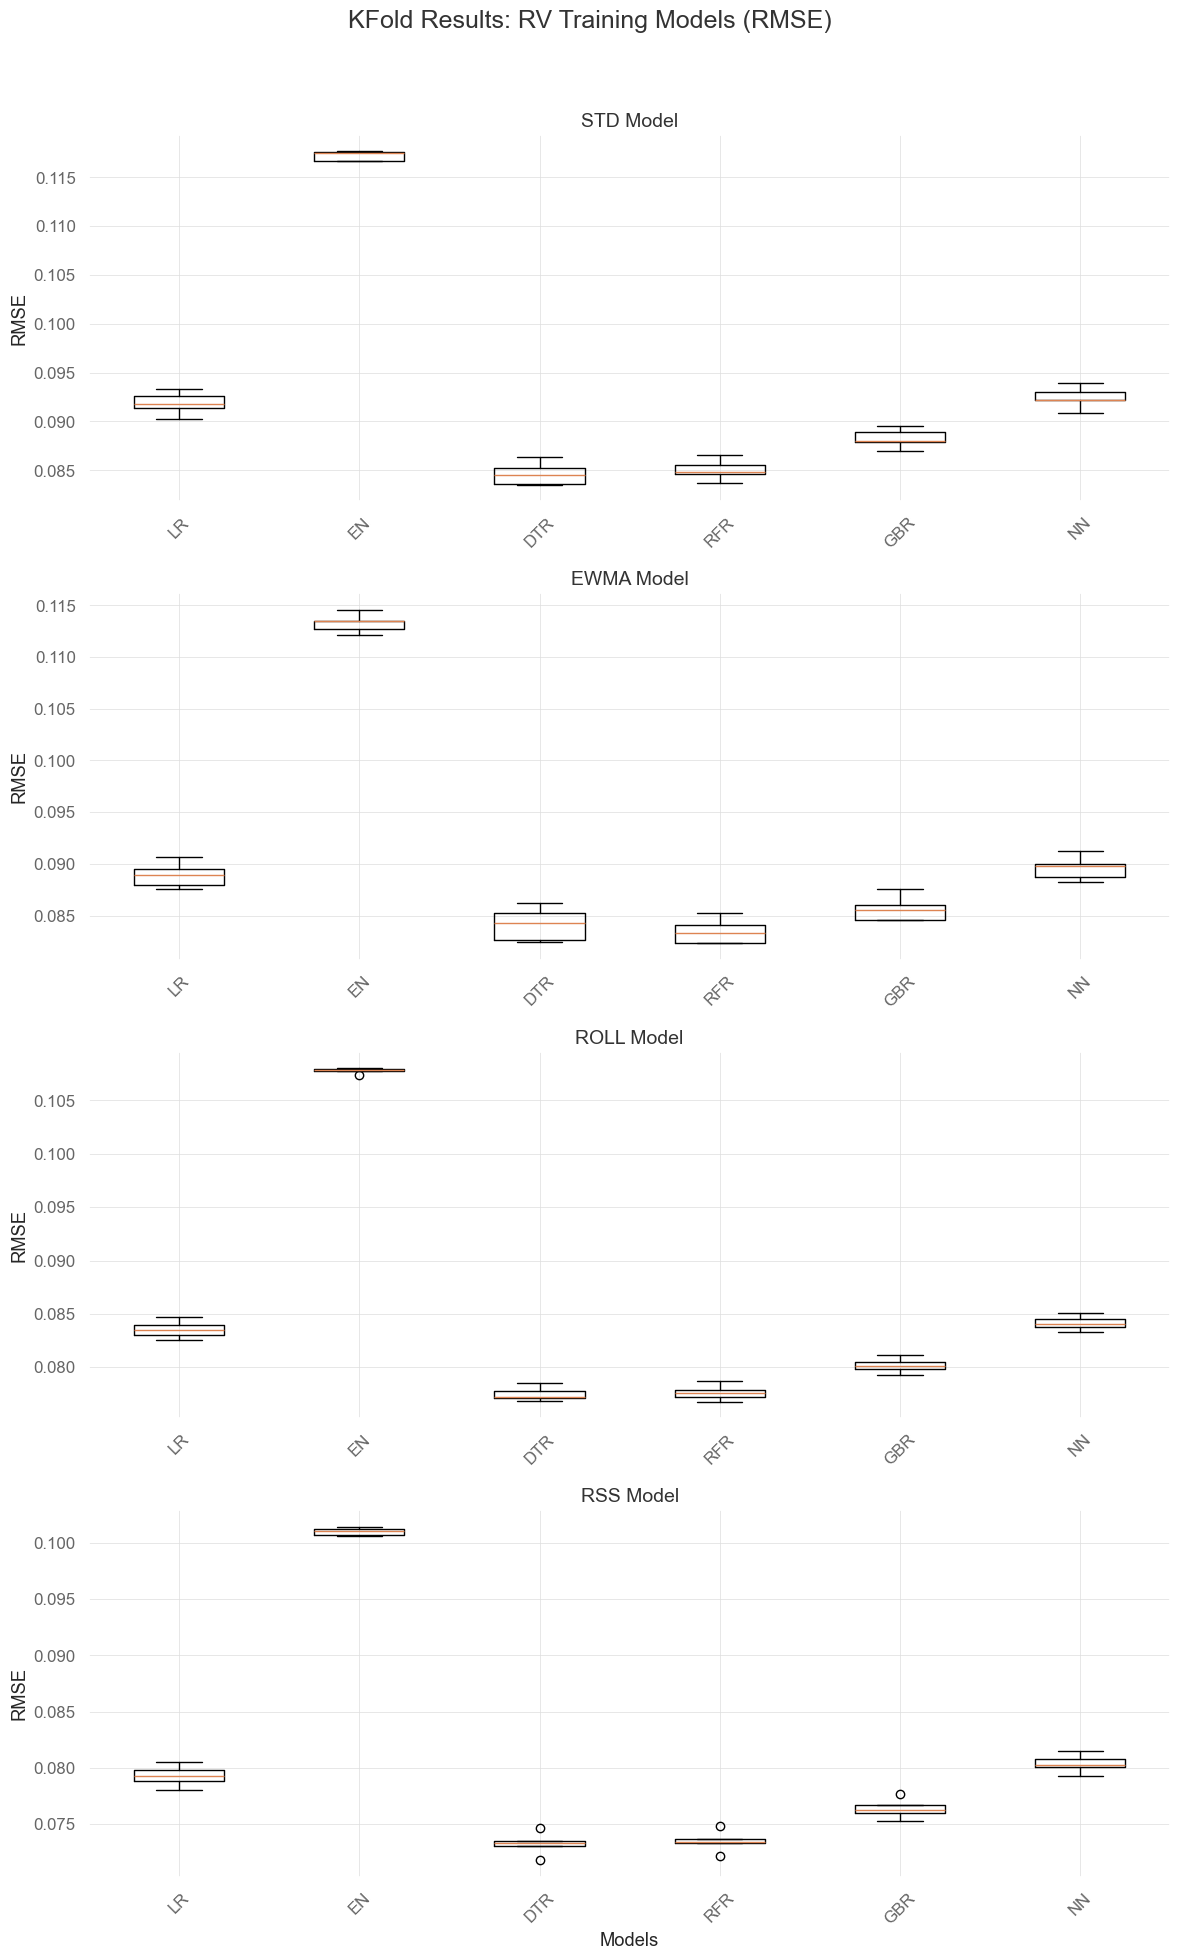

In [25]:
# Dictionary to loop through
all_results = {
    'STD': STD_results,
    'EWMA': EWMA_results,
    'ROLL': ROLL_results,
    'RSS': RSS_results
}

# Set up the figure with subplots (4 rows, 1 column)
fig, axs = pyplot.subplots(4, 1, figsize=(12, 20), sharex=False)
fig.suptitle('KFold Results: RV Training Models (RMSE)', fontsize=18)

for ax, (model_name, result) in zip(axs, all_results.items()):
    kfold_values = list(result['kfold_results'].values())
    model_names = list(result['kfold_results'].keys())

    ax.boxplot(kfold_values)
    ax.set_title(f'{model_name} Model', fontsize=14)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel('RMSE')

axs[-1].set_xlabel('Models')
pyplot.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for the main title
pyplot.show()

In [26]:
summary_records = []

# loop through the all_results dictionary
for model_type, result in all_results.items():
    # loop through each model result and add to dataframe
    for model_name, train_rmse in result['train_results'].items():
        summary_records.append({
            'Model_Type': model_type,
            'Model_Name': model_name,
            'RMSE': train_rmse
        })

train_results = pd.DataFrame(summary_records)
# train_results.to_csv("rmse_train_results.csv", index=False)

In [27]:
train_results = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/rmse_train_results.csv")

<u>**Training Results**</u>  
**STD RV: Decision Tree** -- lowest error and variance  
**EWMA RV: Random Forest Regressor** -- lowest error and lowest variance  
**ROLL RV: Decision Tree** -- lowest error and variance  
**RSS RV: Decision Tree** -- lowest error and variance  

### Predictive Modeing (Testing)

#### Set up testing data (2018-2020)

In [10]:
# see which model is best for each RV metric and apply to testing data
testing = iv_rv_summary[iv_rv_summary['EXPIRY_DT'] >= '2018-01-01']

In [26]:
# filter to necessary columns
test_data = testing.loc[:, ["SYMBOL", "TIMESTAMP", "EXPIRY_DT", "DAYS_TO_EXPIRY_INT", "OPTION_TYP", "IV", \
                              "SECTOR", "STD_RV", "EWMA_RV", "ROLL_RV", "RSS_RV"]]

# ~5 min runtime
test_data = test_data.join(
    test_data.swifter.apply(historical_stats, axis=1).apply(pd.Series)
)

#### Build ML models

In [22]:
# test_data.to_csv('test_model_data.csv', sep=',', index=False, header=True, encoding='utf-8')
test_data_og = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/test_model_data.csv")

# drop rows with null IV
test_data = test_data_og.dropna(subset=['IV'])

# create new variable that takes the log of IV
test_data['ln_IV'] = np.log(test_data['IV'])

In [23]:
# select data to be used in models
# IV, option type, days to expiry, Sector, 90 day lag return, 90 day lag volatility
# only use the trailing volatility for the each respective prediction for simplicity and to avoid multicollinearity
STD_testing_X = test_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'STD_RV_90']]
STD_testing_y = test_data.loc[:, ['STD_RV']]

EWMA_testing_X = test_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'EWMA_RV_90']]
EWMA_testing_y = test_data.loc[:, ['EWMA_RV']]

ROLL_testing_X = test_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'ROLL_RV_90']]
ROLL_testing_y = test_data.loc[:, ['ROLL_RV']]

RSS_testing_X = test_data.loc[:, ['IV', 'ln_IV', 'OPTION_TYP', 'DAYS_TO_EXPIRY_INT', 'SECTOR', 'TOTAL_RTN_90', 'RSS_RV_90']]
RSS_testing_y = test_data.loc[:, ['RSS_RV']]

In [26]:
STD_testing_X = model_preprocessing('STD', 'testing')
EWMA_testing_X = model_preprocessing('EWMA', 'testing')
ROLL_testing_X = model_preprocessing('ROLL', 'testing')
RSS_testing_X = model_preprocessing('RSS', 'testing')

In [27]:
# STD, ROLL, RSS: Decision Tree
# EWMA: Gradient Boosting
STD_model = ROLL_model = RSS_model = DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=1111)
EWMA_model = RandomForestRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=1111, max_features='sqrt', warm_start=True)

test_models = {
    'STD' : STD_model,
    'EWMA': EWMA_model,
    'ROLL': ROLL_model,
    'RSS': RSS_model
}

results_summary = {
        'kfold_results': {},
        'train_results': {}
    }
    
for name, estimator in test_models.items():
    estimator = clone(estimator)  # Create a fresh, untrained copy of the model

    data_X = globals()[f'{name}_testing_X'].copy()
    data_y = globals()[f'{name}_testing_y'].copy()
    
    ## K Fold analysis:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    # Use scoring='neg_root_mean_squared_error' if supported by sklearn version
    cv_results = -1 * cross_val_score(estimator, data_X, data_y, cv=kfold, scoring=scoring)
    results_summary['kfold_results'][name] = cv_results

    # Full Training period RMSE
    fitted_model = estimator.fit(data_X, data_y)
    train_predictions = fitted_model.predict(data_X)
    train_rmse = root_mean_squared_error(data_y, train_predictions)
    results_summary['train_results'][name] = train_rmse

    print(f"{name} Testing: {cv_results.mean():.4f} ({cv_results.std():.4f})")

STD Testing: 0.1276 (0.0030)
EWMA Testing: 0.1116 (0.0021)
ROLL Testing: 0.1122 (0.0022)
RSS Testing: 0.1073 (0.0017)


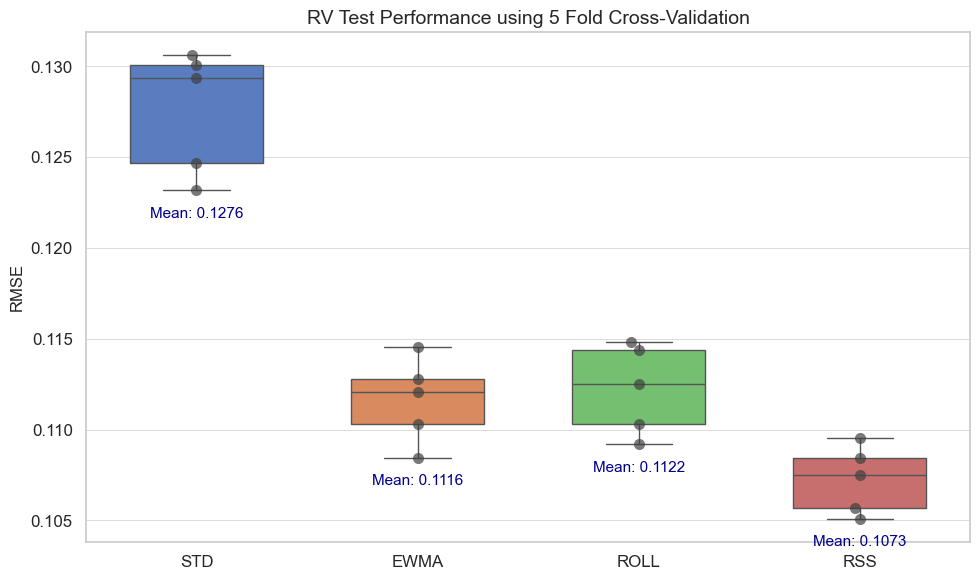

Statistical Summary:
STD:
  Mean: 0.1276
  Std Dev: 0.0030
  Min: 0.1232
  Max: 0.1306

EWMA:
  Mean: 0.1116
  Std Dev: 0.0021
  Min: 0.1084
  Max: 0.1145

ROLL:
  Mean: 0.1122
  Std Dev: 0.0022
  Min: 0.1092
  Max: 0.1148

RSS:
  Mean: 0.1073
  Std Dev: 0.0017
  Min: 0.1051
  Max: 0.1096



In [28]:
# Use the results_summary dictionary directly
# results_summary['kfold_results'] contains our data
results = results_summary['kfold_results']

# Set the style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create box plot
box_plot = sns.boxplot(data=[results['STD'], results['EWMA'], results['ROLL'], results['RSS']], 
                      width=0.6, palette="muted")

# Add a swarm plot to show all data points
sns.swarmplot(data=[results['STD'], results['EWMA'], results['ROLL'], results['RSS']], 
              color=".25", size=8, alpha=0.7)

# Add method names on x-axis
plt.xticks([0, 1, 2, 3], ['STD', 'EWMA', 'ROLL', 'RSS'])

# Set labels and title
plt.ylabel('RMSE', fontsize=12)
plt.title('RV Test Performance using 5 Fold Cross-Validation', fontsize=14)

# Add statistical summary
for i, method in enumerate(['STD', 'EWMA', 'ROLL', 'RSS']):
    mean_val = np.mean(results[method])
    plt.text(i, np.min(results[method]) - 0.0015, f'Mean: {mean_val:.4f}', 
             horizontalalignment='center', size='small', color='darkblue')

plt.tight_layout()
plt.show()

# Print statistical summary
print("Statistical Summary:")
for method in results:
    print(f"{method}:")
    print(f"  Mean: {np.mean(results[method]):.4f}")
    print(f"  Std Dev: {np.std(results[method]):.4f}")
    print(f"  Min: {np.min(results[method]):.4f}")
    print(f"  Max: {np.max(results[method]):.4f}")
    print()

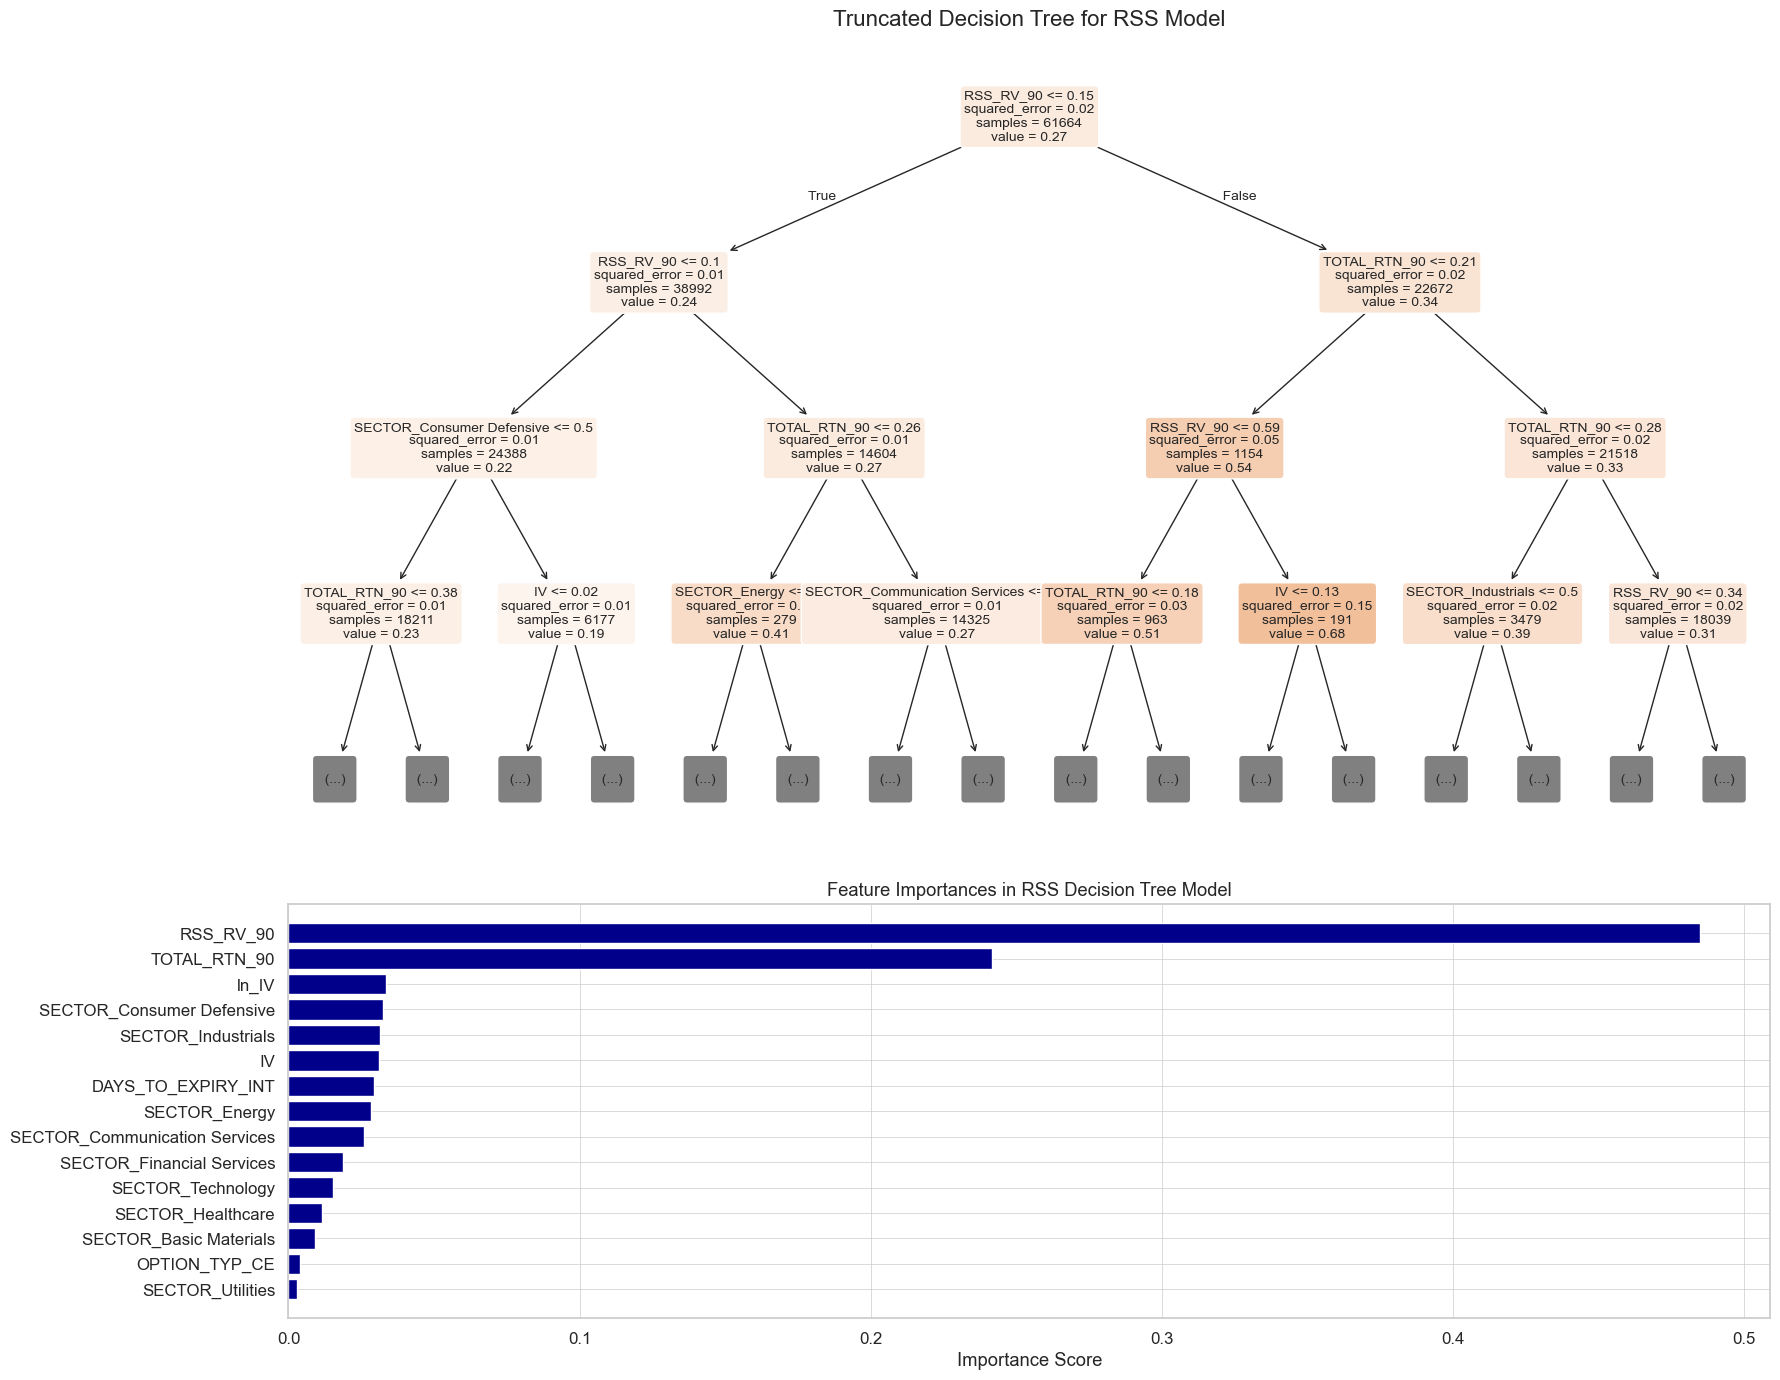

In [29]:
from sklearn import tree

# Fit the model
best_tree = RSS_model.fit(RSS_testing_X, RSS_testing_y)

# Get feature names
feature_names = RSS_testing_X.columns.tolist()

# Get class names (replace with your actual class names if available)
# If class names aren't available, this will use generic labels
try:
    class_names = RSS_model.classes_.tolist()
except:
    class_names = [f'class_{i}' for i in range(len(np.unique(RSS_testing_y)))]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), gridspec_kw={'height_ratios': [2, 1]})

# Plot the decision tree in the first subplot
tree.plot_tree(best_tree, 
               max_depth=3,  # Limit to first three levels
               feature_names=feature_names,
               class_names=class_names,
               filled=True,  # Color nodes by class
               rounded=True,  # Round node corners
               fontsize=10,   # Adjust text size
               precision=2,   # Limit decimal places in values
               ax=ax1)

ax1.set_title('Truncated Decision Tree for RSS Model', fontsize=16)

# Plot feature importances as a horizontal bar chart in the second subplot
importances = best_tree.feature_importances_
indices = np.argsort(importances)

# Plot horizontal bar chart
ax2.barh(range(len(indices)), 
         importances[indices], 
         color='darkblue', 
         align='center')

# Add feature names as y-axis labels
ax2.set_yticks(range(len(indices)))
ax2.set_yticklabels([feature_names[i] for i in indices])

# Add labels and title
ax2.set_xlabel('Importance Score')
ax2.set_title('Feature Importances in RSS Decision Tree Model')

# Adjust the whole layout
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
# Make predictions
predictions_df = test_data.reset_index()

RSS_pred = RSS_model.predict(RSS_testing_X)
predictions_df['RSS_Predicted'] = RSS_pred

# remove the index column which is automatically created after appending predicted values
# offset due to dropping missing IV rows from earlier
predictions_df = predictions_df.drop('index', axis=1)

# Calculate RSS metrics
r2_rss = r2_score(predictions_df['RSS_RV'], predictions_df['RSS_Predicted'])
mae_rss = mean_absolute_error(predictions_df['RSS_RV'], predictions_df['RSS_Predicted'])
rmse_rss = root_mean_squared_error(predictions_df['RSS_RV'], predictions_df['RSS_Predicted'])

In [31]:
predictions_df.head()

,SYMBOL,TIMESTAMP,EXPIRY_DT,DAYS_TO_EXPIRY_INT,OPTION_TYP,IV,SECTOR,STD_RV,EWMA_RV,ROLL_RV,RSS_RV,STD_RV_90,EWMA_RV_90,ROLL_RV_90,RSS_RV_90,TOTAL_RTN_90,ln_IV,RSS_Predicted
0,AMBUJACEM,2020-08-31,2020-10-29,59,CE,0.8051,Basic Materials,0.3530,0.3883,0.3115,0.3043,0.3033,0.2918,0.2779,0.2566,0.1012,-0.2167,0.2533
1,AMBUJACEM,2020-08-31,2020-10-29,59,PE,0.4550,Basic Materials,0.3530,0.3883,0.3115,0.3043,0.3033,0.2918,0.2779,0.2566,0.1012,-0.7874,0.2533
2,AMBUJACEM,2020-08-27,2020-10-29,63,CE,0.5856,Basic Materials,0.3451,0.3304,0.3193,0.2947,0.2839,0.2869,0.2833,0.2413,0.1556,-0.5351,0.2533
3,AMBUJACEM,2020-08-27,2020-10-29,63,PE,0.5637,Basic Materials,0.3451,0.3304,0.3193,0.2947,0.2839,0.2869,0.2833,0.2413,0.1556,-0.5732,0.2533
4,ASHOKLEY,2020-08-31,2020-10-29,59,CE,0.1665,Industrials,0.5550,0.5568,0.5010,0.4756,0.5367,0.5030,0.4638,0.4585,0.4182,-1.7928,0.4347


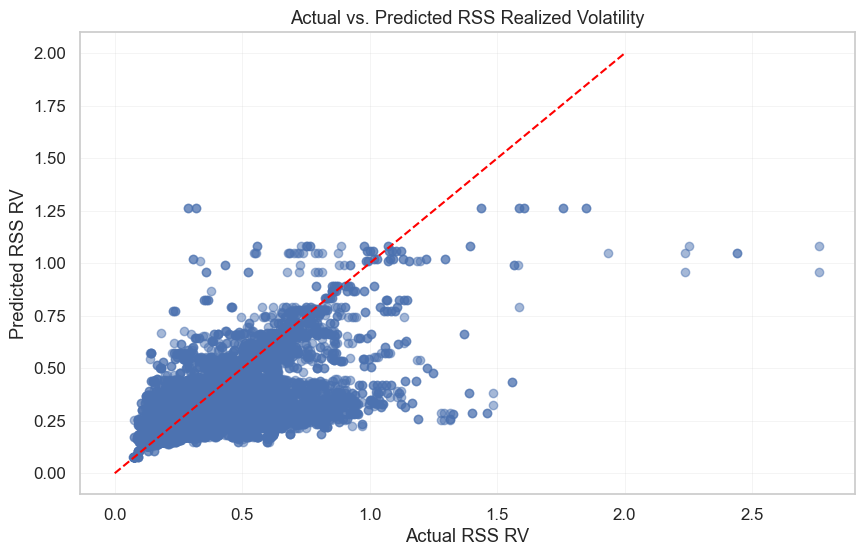

In [68]:
# Actual vs Predicted RSS values

plt.scatter(predictions_df['RSS_RV'], predictions_df['RSS_Predicted'], alpha=0.5, label='RSS Model')
# plt.scatter(result_df['Actual_RSS_RV'], result_df['GARCH_Predicted'], alpha=0.5, label='GARCH Model')
min_val = 0.0 # min(result_df['Actual_RSS_RV'].min(), result_df['RSS_Predicted'].min()) #, result_df['GARCH_Predicted'].min())
max_val = 2.0 # max(result_df['Actual_RSS_RV'].max(), result_df['RSS_Predicted'].max()) #, result_df['GARCH_Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')  # Diagonal line
plt.xlabel("Actual RSS RV")
plt.ylabel("Predicted RSS RV")
plt.title("Actual vs. Predicted RSS Realized Volatility")
# plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

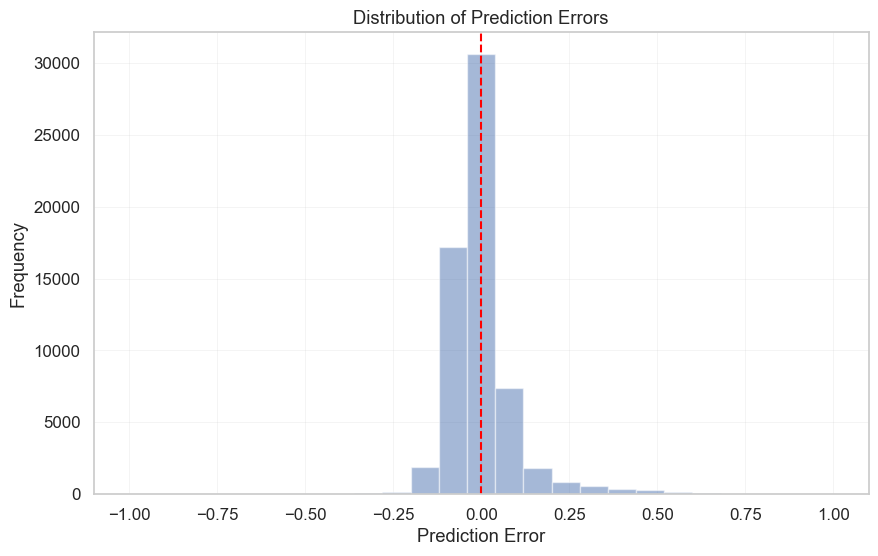

In [69]:
# Prediction error distribution

plt.hist(predictions_df['RSS_RV'] - predictions_df['RSS_Predicted'], bins=25, alpha=0.5, range = (-1.0, 1.0), label='RSS Error')
# plt.hist(result_df['Actual_RSS_RV'] - result_df['GARCH_Predicted'], bins=30, alpha=0.5, label='GARCH Error')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
# plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# most errors within -0.04 to 0.04 ... very good

In [70]:
RSS_errors = pd.DataFrame(predictions_df['RSS_RV'] - predictions_df['RSS_Predicted'])
RSS_errors.describe()

,0
count,"61,664.00000"
mean,-0.00000
std,0.10157
min,-0.97471
25%,-0.05005
50%,-0.01377
75%,0.02335
max,1.80465


#### Build a GARCH model

In [134]:
from arch import arch_model

def calculate_garch_volatility(df, final_tickers):
    """
    Calculates GARCH (1,1) forecasted volatility for given tickers after '2018-01-01'.

    Args:
        df (pd.DataFrame): The input DataFrame with historical price data.
        final_tickers (list): A list of ticker symbols.

    Returns:
        pd.DataFrame: The DataFrame with added GARCH volatility forecast columns.
    """

    for ticker in final_tickers:

        print(f"Fitting GARCH model for: {ticker}")
        
        # Extract Log Returns
        return_col = f'{ticker}_LogRtn'
        if return_col not in df.columns:
            print(f"Log return column '{return_col}' not found. Skipping {ticker}.")
            continue

        # Convert index to datetime
        df.index = pd.to_datetime(df.index)
        returns = 100*df[return_col].dropna()
        
        # Filter data for forecasting
        split_date = datetime(2017, 11, 1)
        forecast_dates = df.index[df.index >= split_date]
        returns_for_model = returns[returns.index < split_date]  # Use data before split_date to train GARCH

        # Build and Fit GARCH Model
        try:
            garch_model = arch_model(returns_for_model,
                                     mean='Zero',
                                     vol='GARCH',
                                     p=10,
                                     q=3)  # GARCH(10, 3)
            garch_fit = garch_model.fit(disp='off')  # Suppress output during fitting
    
            # Forecast Volatility
            horizon = len(forecast_dates)  # Set forecast horizon
            forecasts = garch_fit.forecast(horizon=len(forecast_dates))
            volatility_forecasts = np.sqrt(forecasts.variance.values[-1, :]) / 100
            volatility_series = pd.Series(volatility_forecasts, index=forecast_dates)
            df[f'{ticker}_GARCH'] = np.nan
            df.loc[volatility_series.index, f'{ticker}_GARCH'] = volatility_series.values

        # catch errors if they occur
        except Exception as e:
            print(f"Error fitting GARCH model for {ticker}: {e}")
            df[f'{ticker}_GARCH'] = np.nan  # Ensure the column exists even on error
            
    return df

In [135]:
# create new dataframe with GARCH forecasts
priceHistory_GARCH = calculate_garch_volatility(priceHistory, final_tickers)

Fitting GARCH model for: BHARATFORG.NS
Fitting GARCH model for: JINDALSAW.NS
Fitting GARCH model for: BOMDYEING.NS
Fitting GARCH model for: TATASTEEL.NS
Fitting GARCH model for: PURVA.NS
Fitting GARCH model for: HINDALCO.NS
Fitting GARCH model for: ZEEL.NS
Fitting GARCH model for: HINDUNILVR.NS
Fitting GARCH model for: UNITECH.NS
Fitting GARCH model for: ONGC.NS
Fitting GARCH model for: PUNJLLOYD.NS
Fitting GARCH model for: PRAJIND.NS
Fitting GARCH model for: TRIVENI.NS
Fitting GARCH model for: J&KBANK.NS
Fitting GARCH model for: HCC.NS
Fitting GARCH model for: PATELENG.NS
Fitting GARCH model for: PETRONET.NS
Fitting GARCH model for: INDUSINDBK.NS
Fitting GARCH model for: SAIL.NS
Fitting GARCH model for: ASHOKLEY.NS
Fitting GARCH model for: STAR.NS
Fitting GARCH model for: JSWSTEEL.NS
Fitting GARCH model for: AMBUJACEM.NS
Fitting GARCH model for: TVSMOTOR.NS
Fitting GARCH model for: ROLTA.NS
Fitting GARCH model for: WIPRO.NS
Fitting GARCH model for: BRIGADE.NS
Fitting GARCH model for: 

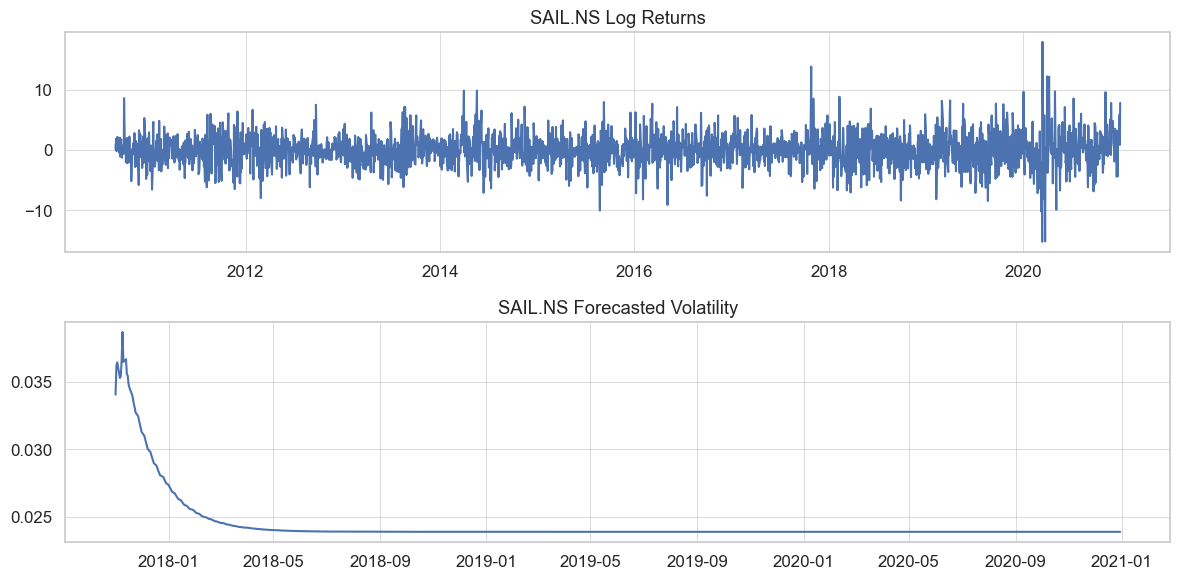

In [136]:
# Plot returns and volatility
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(100*priceHistory_GARCH['SAIL.NS_LogRtn'].dropna())
plt.title(f'SAIL.NS Log Returns')
plt.subplot(2, 1, 2)
plt.plot(priceHistory_GARCH['SAIL.NS_GARCH'])
plt.title(f'SAIL.NS Forecasted Volatility')
plt.tight_layout()
plt.show()

In [137]:
# function to annualize daily GARCH forecasts
def annual_GARCH(start_dt, end_dt, stock):
    GARCH_forecast = priceHistory_GARCH.loc[start_dt:end_dt, stock].values
    return np.mean(GARCH_forecast) * np.sqrt(252)

GARCH_vols = []

# pull out contract information to be pulled from GARCH forecasts and append to array
for idx, row in predictions_df.iterrows():
    start_dt = row['TIMESTAMP']
    end_dt = row['EXPIRY_DT']
    stock = row['SYMBOL'] + '.NS_GARCH'

    annual_vol = annual_GARCH(start_dt, end_dt, stock)

    GARCH_vols.append(annual_vol)

# merge with predictions dataset for analysis
predictions_df['GARCH_Predicted'] = GARCH_vols

In [142]:
predictions_df

,SYMBOL,TIMESTAMP,EXPIRY_DT,DAYS_TO_EXPIRY_INT,OPTION_TYP,IV,SECTOR,STD_RV,EWMA_RV,ROLL_RV,RSS_RV,STD_RV_90,EWMA_RV_90,ROLL_RV_90,RSS_RV_90,TOTAL_RTN_90,ln_IV,RSS_Predicted,GARCH_Predicted
0,AMBUJACEM,2020-08-31,2020-10-29,59,CE,0.8051,Basic Materials,0.3530,0.3883,0.3115,0.3043,0.3033,0.2918,0.2779,0.2566,0.1012,-0.2167,0.2533,0.2991
1,AMBUJACEM,2020-08-31,2020-10-29,59,PE,0.4550,Basic Materials,0.3530,0.3883,0.3115,0.3043,0.3033,0.2918,0.2779,0.2566,0.1012,-0.7874,0.2533,0.2991
2,AMBUJACEM,2020-08-27,2020-10-29,63,CE,0.5856,Basic Materials,0.3451,0.3304,0.3193,0.2947,0.2839,0.2869,0.2833,0.2413,0.1556,-0.5351,0.2533,0.2991
3,AMBUJACEM,2020-08-27,2020-10-29,63,PE,0.5637,Basic Materials,0.3451,0.3304,0.3193,0.2947,0.2839,0.2869,0.2833,0.2413,0.1556,-0.5732,0.2533,0.2991
4,ASHOKLEY,2020-08-31,2020-10-29,59,CE,0.1665,Industrials,0.5550,0.5568,0.5010,0.4756,0.5367,0.5030,0.4638,0.4585,0.4182,-1.7928,0.4347,0.3904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61659,ZEEL,2017-11-24,2018-01-25,62,PE,0.6139,Communication Services,0.1996,0.1903,0.1919,0.1689,0.2311,0.2064,0.1937,0.1944,0.1025,-0.4879,0.2331,0.3096
61660,ZEEL,2017-11-23,2018-01-25,63,CE,0.2774,Communication Services,0.1976,0.1840,0.1930,0.1679,0.2328,0.2057,0.1922,0.1944,0.1044,-1.2822,0.2331,0.3096
61661,ZEEL,2017-11-23,2018-01-25,63,CE,0.2934,Communication Services,0.1976,0.1840,0.1930,0.1679,0.2328,0.2057,0.1922,0.1944,0.1044,-1.2261,0.2331,0.3096
61662,ZEEL,2017-11-23,2018-01-25,63,PE,0.6139,Communication Services,0.1976,0.1840,0.1930,0.1679,0.2328,0.2057,0.1922,0.1944,0.1044,-0.4879,0.2331,0.3096


In [139]:
# Calculate GARCH metrics
r2_garch = r2_score(predictions_df['RSS_RV'], predictions_df['GARCH_Predicted'])
mae_garch = mean_absolute_error(predictions_df['RSS_RV'], predictions_df['GARCH_Predicted'])
rmse_garch = root_mean_squared_error(predictions_df['RSS_RV'], predictions_df['GARCH_Predicted'])

In [141]:
# save to CSV for future reference
# predictions_df.to_csv('predictions_df.csv', index=False)
predictions_df = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/predictions_df.csv")

### Summarize testing results

In [143]:
# Print metrics for both models
print("\n==== Prediction Performance Metrics ====")
print(f"RSS Model")
print(f"R²: {r2_rss:.4f}\nMAE: {mae_rss:.4f}\nRMSE: {rmse_rss:.4f}\n")

print(f"GARCH Model")
print(f"R²: {r2_garch:.4f}\nMAE: {mae_garch:.4f}\nRMSE: {rmse_garch:.4f}")


==== Prediction Performance Metrics ====
RSS Model
R²: 0.4598
MAE: 0.0612
RMSE: 0.1016

GARCH Model
R²: -0.0293
MAE: 0.1072
RMSE: 0.1402


### Perform a simulated trading strategy

In [156]:
predictions_df_RSS = predictions_df.drop(['STD_RV', 'EWMA_RV', 'ROLL_RV', 'STD_RV_90', 'EWMA_RV_90', 'ROLL_RV_90'], axis=1)

# join back original data frame to get option pricing
trading_df = pd.merge(testing, predictions_df_RSS, on=['SYMBOL', 'TIMESTAMP', 'EXPIRY_DT', 'OPTION_TYP'], how='inner')

# select only the necessary columns
trading_df = trading_df.loc[:, ['SYMBOL', 'TIMESTAMP', 'EXPIRY_DT', 'DAYS_TO_EXPIRY_INT_x', 'Price',
       'Price_Ex', 'STRIKE_PR', 'OPTION_TYP', 'CLOSE', 'RSS_RV_x', 'RSS_RV_90', 'RSS_Predicted', 'GARCH_Predicted']]

# rename for clarity
trading_df = trading_df.rename(columns={'RSS_RV_x': 'RSS_RV', 'DAYS_TO_EXPIRY_INT_x': 'DAYS_TO_EXPIRY_INT'})

# remove duplicate rows and reset index
trading_df = trading_df.drop_duplicates().reset_index()

# trading_df.to_csv("portfolio_trading.csv", index=False)

In [145]:
# if forecasted RV > IV, then buy the option, otherwise sell it
trading_df = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/portfolio_trading.csv")

In [146]:
# define actions for each variable
trading_df['Action_RSS'] = ['Buy' if row['RSS_Predicted'] >= row['RSS_RV'] else 'Sell' for idx, row in trading_df.iterrows()]
trading_df['Action_GARCH'] = ['Buy' if row['GARCH_Predicted'] >= row['RSS_RV'] else 'Sell' for idx, row in trading_df.iterrows()]

# determine intial cost basis
trading_df['C_0_RSS'] = [row['CLOSE'] if row['Action_RSS'] == 'Sell' else -1*row['CLOSE'] for idx, row in trading_df.iterrows()]
trading_df['C_0_GARCH'] = [row['CLOSE'] if row['Action_GARCH'] == 'Sell' else -1*row['CLOSE'] for idx, row in trading_df.iterrows()]

In [147]:
def calculate_payoff_2(row):
    if row["OPTION_TYP"] == 'CE':  # Call option
        if row["Action_RSS"] == 'Buy' or row["Action_GARCH"] == 'Buy':
            return max(row["Price_Ex"] - row["STRIKE_PR"], 0)
        else:
            return min(row["STRIKE_PR"] - row["Price_Ex"], 0)
            
    elif row["OPTION_TYP"] == 'PE':
        if row["Action_RSS"] == 'Buy' or row["Action_GARCH"] == 'Buy':
            return max(row["STRIKE_PR"] - row["Price_Ex"], 0)
        else:
            return min(row["Price_Ex"] - row["STRIKE_PR"], 0)

In [148]:
trading_df["Payoff_RSS"] = trading_df.apply(calculate_payoff_2, axis=1)
trading_df["Payoff_GARCH"] = trading_df.apply(calculate_payoff_2, axis=1)

trading_df["Profit_RSS"] = trading_df["C_0_RSS"] + trading_df["Payoff_RSS"]
trading_df["Profit_GARCH"] = trading_df["C_0_GARCH"] + trading_df["Payoff_GARCH"]

In [149]:
trading_profits = trading_df.loc[:, ["TIMESTAMP", "EXPIRY_DT", "SYMBOL", "DAYS_TO_EXPIRY_INT", "OPTION_TYP", "Profit_RSS", "Profit_GARCH"]]

In [150]:
trading_profits = trading_profits.sort_values(by="EXPIRY_DT").reset_index()
trading_profits.head()

,index,TIMESTAMP,EXPIRY_DT,SYMBOL,DAYS_TO_EXPIRY_INT,OPTION_TYP,Profit_RSS,Profit_GARCH
0,64119,2017-11-23,2018-01-25,ZEEL,63,PE,-57.6000,-57.6000
1,62617,2017-12-04,2018-01-25,INDUSINDBK,52,CE,-21.0000,-21.0000
2,62618,2017-12-04,2018-01-25,INDUSINDBK,52,PE,-96.9500,-96.9500
3,62619,2017-12-04,2018-01-25,INDUSINDBK,52,PE,-107.6000,-107.6000
4,62620,2017-12-01,2018-01-25,INDUSINDBK,55,CE,-21.0000,-21.0000


In [151]:
portfolio = pd.DataFrame(trading_profits.groupby("EXPIRY_DT")[["Profit_RSS", "Profit_GARCH"]].sum())

starting_balance = 100_000_000

# Calculate running total
portfolio['RSS_Position'] = starting_balance + portfolio['Profit_RSS'].cumsum()
portfolio['GARCH_Position'] = starting_balance + portfolio['Profit_GARCH'].cumsum()

# Calculate running return in %
portfolio['Running_RSS_Gain'] = ((portfolio['RSS_Position'] / starting_balance) - 1)
portfolio['Running_GARCH_Gain'] = ((portfolio['GARCH_Position'] / starting_balance) - 1)

In [152]:
# Pull in Nifty Fifty index values for benchmark performance
# '^NSEI' is the Yahoo Finance ticker for NIFTY 50

# make sure the index is a datetime format
portfolio.index = pd.to_datetime(portfolio.index)

nifty = yf.download(
    '^NSEI',
    start='2018-01-01',
    end=portfolio.index.max().strftime('%Y-%m-%d'),
    auto_adjust=False
)

# Extract closing prices
nifty_close = nifty['Adj Close']

# Reindex NIFTY close prices to match your trading_profits dates
# Nearest date if exact match is missing
nifty_close_on_expiry = nifty_close.reindex(portfolio.index, method='nearest')

# Normalize the NIFTY movement
# Set first value as 100,000,000
initial_investment = 100_000_000
nifty_returns = nifty_close_on_expiry / nifty_close_on_expiry.iloc[0]  # Normalize to 1
nifty_portfolio_value = initial_investment * nifty_returns

# Add to your DataFrame
portfolio['Nifty_Position'] = nifty_portfolio_value
# Calculate running return in %
portfolio['Running_Nifty_Gain'] = ((portfolio['Nifty_Position'] / initial_investment) - 1)

[*********************100%***********************]  1 of 1 completed


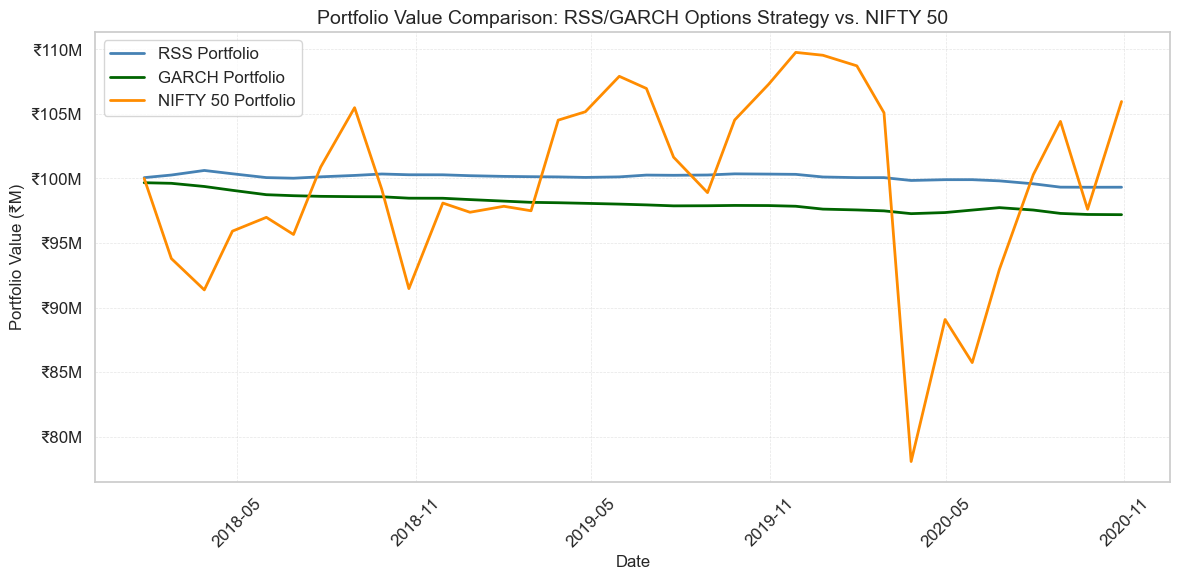

In [153]:
# function to reformat y-axis values
def millions(x, pos):
    return f'₹{x*1e-6:,.0f}M'

plt.figure(figsize=(12, 6))

# Plotting both portfolios
plt.plot(portfolio.index, portfolio['RSS_Position'], label='RSS Portfolio', color='steelblue', linewidth=2)
plt.plot(portfolio.index, portfolio['GARCH_Position'], label='GARCH Portfolio', color='darkgreen', linewidth=2)
plt.plot(portfolio.index, portfolio['Nifty_Position'], label='NIFTY 50 Portfolio', color='darkorange', linewidth=2)

# Title and labels
plt.title('Portfolio Value Comparison: RSS/GARCH Options Strategy vs. NIFTY 50', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value (₹M)', fontsize=12)

# Y-axis formatter to display in millions
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

# X-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [155]:
# portfolio.to_csv("final_portfolio.csv", index=True)
portfolio = pd.read_csv("C:/Users/njpittman/OneDrive - University of Iowa/G2 Spring/FIN 9160/Final Project/final_portfolio.csv", index_col = 0)
portfolio

,Profit_RSS,Profit_GARCH,RSS_Position,GARCH_Position,Running_RSS_Gain,Running_GARCH_Gain,Nifty_Position,Running_Nifty_Gain
EXPIRY_DT,,,,,,,,
2018-01-25,"63,411.0146","-329,423.9854","100,063,411.0146","99,670,576.0146",0.0006,-0.0033,"100,000,000.0000",0.0000
2018-02-22,"202,470.2832","-46,344.5168","100,265,881.2978","99,624,231.4978",0.0027,-0.0038,"93,794,291.8604",-0.0621
2018-03-28,"354,028.0130","-245,568.1870","100,619,909.3108","99,378,663.3108",0.0062,-0.0062,"91,364,224.1482",-0.0864
2018-04-26,"-256,513.1370","-297,752.1370","100,363,396.1739","99,080,911.1739",0.0036,-0.0092,"95,918,113.3099",-0.0408
2018-05-31,"-296,371.6069","-338,936.5069","100,067,024.5670","98,741,974.6670",0.0007,-0.0126,"96,987,258.0594",-0.0301
2018-06-28,"-47,817.8879","-77,812.7879","100,019,206.6791","98,664,161.8791",0.0002,-0.0134,"95,658,844.0981",-0.0434
2018-07-26,"107,833.1243","-49,858.6757","100,127,039.8033","98,614,303.2033",0.0013,-0.0139,"100,882,136.3875",0.0088
2018-08-30,"107,887.7789","-24,897.2211","100,234,927.5822","98,589,405.9822",0.0023,-0.0141,"105,484,811.1064",0.0548
2018-09-27,"111,295.8985","-7,999.6015","100,346,223.4807","98,581,406.3807",0.0035,-0.0142,"99,167,990.1109",-0.0083
